In [1]:
#profiler load 
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../..')
from pyprofiler.utils import config_utils
import pyprofiler.utils.goatools_utils as goa
import pyprofiler.profiler as profiler
from qtlsearch.OBOParser import OBO
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#select rand profile w annotations
#mask annotations
#pull in coevolving Hogs
#feed profile vectors and GO to NN
#Try to recover annotations

{'dir': {'datadir': '/home/cactuskid13/pyprofiler/pyprofiler/all/all/', 'omadir': '/home/cactuskid13/mntpt/OMA/latest/'}, 'orthoxmltar': '', 'email': 'dmoi@unil.ch'}


In [2]:
#lets also create a go annotation enrichment study object to describe functional enrichment in our profiling results

gaf = goa.buildGAF( '/home/cactuskid13/mntpt/OMA/latest/oma-go.txt' )

In [3]:
#load oma hogs to prot sequence mapping

import gzip
import pickle
with gzip.open('oma-hogs-Jun2019.p.gz', 'rb') as fp:
    hogs = pickle.load(fp)
print(list(hogs.keys())[0:10])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [4]:
from goatools import obo_parser
obo = './go.obo'
obo = obo_parser.GODag(obo)

./go.obo: fmt(1.2) rel(2019-12-09) 47,311 GO Terms


In [5]:
p = profiler.Profiler(lshforestpath = config_utils.datadir + '/latest_all_256/newlshforest.pkl'  , hashes_h5=config_utils.datadir+ 'latest_all_256/hashes.h5'  , mat_path= None, oma = '/home/cactuskid13/mntpt/OMA/latest/OmaServer.h5', tar= None , mastertree =config_utils.datadir + 'latest_all_256_master_tree.pkl' , nsamples = 256)

loading lsh
indexing lsh


Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "../../../pyprofiler/pyoma/browser/db.py", line 879, in __init__
    self.seq_idx = self.seq_idx()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/link.py", line 397, in __call__
    self.extfile = tables.open_file(filename, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 784, in __init__
    self._g_new(filename, mode, **params)
  File "tables/hdf5extension.pyx", line 374, in tables.hdf5extension.File._g_new
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/utils.py", line 157, in check_file_access
    raise IOError("``%s`` does not exist" % (fil

3278
DONE


In [6]:
import time
import itertools

species = pd.read_table( './oma-species.txt' , sep = '\t' , comment = '#', header = None)
specdict = dict( zip(species[0] , species[1]) )

def yeild_annot_hogs( hogs, specdict, chunksize = 10 , verbose = False):
    datachunkdict = {}
    datadf = None
    for h in itertools.cycle(hogs):
        if h> 0:
            if datadf is not None and len(datadf) > 0 and len(datadf.hog.unique())> chunksize:
                datadf['taxcode'] = datadf.genome.map(specdict)
                yield datadf
                datachunkdict = {}
                datadf = None
            if verbose :
                print(h)
            
            datachunkdict= { m:{ 'genome':m[0:5],  'annot': gaf[m] , 'hog':h } for m in hogs[h] if m in gaf }
            if len(datachunkdict)>10:
                if datadf is None:
                    datadf = pd.DataFrame.from_dict( datachunkdict , orient = 'index' )
                else:
                    datadf = pd.concat([datadf , pd.DataFrame.from_dict( datachunkdict , orient = 'index' ) ])

hogiterator = yeild_annot_hogs( hogs , specdict )

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.


In [7]:

for i in range(5):
    t0 = time.time()
    next(hogiterator)
    print( time.time()-t0)

print( next(hogiterator).head() )

0.22692537307739258
0.05514073371887207
0.1800556182861328
0.04569244384765625
0.05126619338989258
           genome                                 annot   hog  taxcode
CALMQ00997  CALMQ  {GO:0003677, GO:0000150, GO:0006310}  3223   397948
PYRAE02475  PYRAE  {GO:0003677, GO:0000150, GO:0006310}  3223   178306
PYRAR01890  PYRAR  {GO:0003677, GO:0000150, GO:0006310}  3223   340102
PYRCJ01941  PYRCJ  {GO:0003677, GO:0000150, GO:0006310}  3223   410359
PYRIL00788  PYRIL  {GO:0003677, GO:0000150, GO:0006310}  3223   384616


In [8]:
targets = pd.read_table( './out_map_by_hog.tsv')
targets = targets.sort_values( by= 'oma_id')
targets['species'] = targets.oma_id.map( lambda x : x[0:5])
print(targets.head())
targets['taxcode'] = targets.species.map(specdict)
print(targets.head())


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


            cafa_id      oma_id     fam species
57070  T37020001074  ARATH00006  472976   ARATH
69814  T37020003425  ARATH00010  483443   ARATH
70000  T37020007063  ARATH00011  483592   ARATH
3798   T37020007582  ARATH00013  182502   ARATH
3236   T37020015139  ARATH00015  177269   ARATH
            cafa_id      oma_id     fam species  taxcode
57070  T37020001074  ARATH00006  472976   ARATH     3702
69814  T37020003425  ARATH00010  483443   ARATH     3702
70000  T37020007063  ARATH00011  483592   ARATH     3702
3798   T37020007582  ARATH00013  182502   ARATH     3702
3236   T37020015139  ARATH00015  177269   ARATH     3702


In [9]:
def fam2hogid(fam_id):
    """
    For use with OMA HOGs
    Get hog id given fam
    :param fam_id: fam
    :return: hog id
    """
    hog_id = "HOG:" + (7-len(str(fam_id))) * '0' + str(fam_id)
    return hog_id

def hogid2fam(hog_id):
    """
    For use with OMA HOGs
    Get hog id given fam
    :param fam_id: fam
    :return: hog id
    """
    fam_id = int(hog_id.split(':')[1])
    return fam_id

def id2GO(intID):
    return 'GO:{:07d}'.format(intID)


def id2GO(intID):
    return 'GO:{:07d}'.format(intID)

def go2id(strID):
    if type( strID) is int:
        return strID
    return int(strID.split(':')[1])



def get_ancestors( golist , obo,  levels = 4 ):
    ancestors = []
    
    for l in range( levels):
        try:
            if l == 0 :
                a = [ obo[p.id].id for g in golist for p in obo[g].parents if g in obo and p.id in obo ]
            else:
                a = [ obo[p.id].id for g in a for p in obo[g].parents if g in obo and p.id in obo ]
            ancestors += a
        except:
            pass
    ancestors += golist
    return [goa.goterm2id(goterm) for goterm in set(ancestors)]

def get_ancestors_all( golist , obo):
    ancestors = []
    lastlen = -1
    l = 0
    while len(ancestors)>lastlen:
        if l == 0 :
            a = [ obo[p.id].id for g in golist for p in obo[g].parents if g in obo and p.id in obo]
            
        else:
            a = [ obo[p.id].id for g in a for p in obo[g].parents if g in obo and p.id in obo ]
        lastlen = len(ancestors)
        ancestors += a
        l+=1
    
    ancestors += golist
    return [goa.goterm2id(goterm) for goterm in set(ancestors)]

In [16]:
qhog = '479378'
res = p.hog_query(fam_id=int(qhog) , k = 100)
res +=['479378']

#res =[ "HOG:" + (7-len(str(fam_id))) * '0' + str(fam_id) for fam_id in res ]
godict = { r:  { m:gaf[m]  for m in hogs[int(r)] if m in gaf} for r in res}
print(godict['479378'])
godict = { r: get_ancestors ( set([ g  for go in godict[r].values() for g in go] ) , obo ) for r in godict }
hashes =  p.pull_hashes(res)
jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in hashes }


{'ICHMG07310': {'GO:0016021', 'GO:0016020'}, 'ORYPU32013': {'GO:0016021'}, 'DICDI03960': {'GO:0003674', 'GO:0008150', 'GO:0005575', 'GO:0016021'}, 'GOSRA46123': {'GO:0008289', 'GO:0016020', 'GO:0009567', 'GO:0048235', 'GO:0005886', 'GO:0061936', 'GO:0007338', 'GO:0016021', 'GO:0005783', 'GO:0005887', 'GO:0045026'}, 'POPTR27565': {'GO:0008289', 'GO:0007338', 'GO:0016020', 'GO:0005886', 'GO:0016021', 'GO:0005783'}, 'ORYLO14359': {'GO:0016021'}, 'ORYSJ22678': {'GO:0008289', 'GO:0007338', 'GO:0016020', 'GO:0005886', 'GO:0016021', 'GO:0005783', 'GO:0005789'}, 'LUPAN02887': {'GO:0016021'}, 'ARALY23192': {'GO:0008289', 'GO:0007338', 'GO:0005886', 'GO:0016021', 'GO:0005783'}, 'TRYCC07250': {'GO:0016021', 'GO:0016020'}, 'ARATH26614': {'GO:0008289', 'GO:0007338', 'GO:0009567', 'GO:0016020', 'GO:0005886', 'GO:0048235', 'GO:0061936', 'GO:0016021', 'GO:0005783', 'GO:0005887', 'GO:0005789', 'GO:0045026'}, 'SOYBN21949': {'GO:0016021', 'GO:0016020'}, 'ORYSI37165': {'GO:0016021'}, 'WHEAT87894': {'GO:00

[0.21875, 0.234375, 0.23828125, 0.2421875, 0.25390625, 0.26171875, 0.28125, 0.29296875, 0.296875, 0.30078125, 0.3046875, 0.3046875, 0.30859375, 0.3203125, 0.3203125, 0.328125, 0.328125, 0.34375, 0.34375, 0.34765625, 0.35546875, 0.35546875, 0.35546875, 0.35546875, 0.359375, 0.359375, 0.36328125, 0.36328125, 0.36328125, 0.37109375, 0.37890625, 0.3828125, 0.3828125, 0.3828125, 0.3828125, 0.38671875, 0.38671875, 0.38671875, 0.38671875, 0.390625, 0.390625, 0.39453125, 0.39453125, 0.39453125, 0.39453125, 0.40234375, 0.40234375, 0.40234375, 0.40234375, 0.40234375, 0.40234375, 0.40625, 0.41015625, 0.41015625, 0.4140625, 0.4140625, 0.41796875, 0.41796875, 0.41796875, 0.421875, 0.421875, 0.421875, 0.42578125, 0.42578125, 0.4296875, 0.4296875, 0.4296875, 0.43359375, 0.43359375, 0.4375, 0.4375, 0.4375, 0.4375, 0.44140625, 0.44140625, 0.4453125, 0.4453125, 0.4453125, 0.44921875, 0.44921875, 0.4609375, 0.4609375, 0.46484375, 0.46484375, 0.46484375, 0.46875, 0.46875, 0.47265625, 0.47265625, 0.4765625

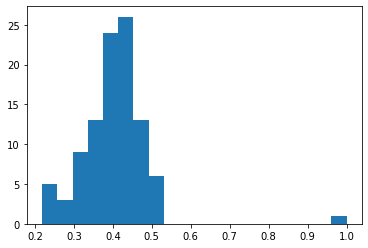

In [17]:
plt.hist(jaccards.values(), 20)
print(sorted(jaccards.values()))
#each annotation set has a weight with jaccard...



In [73]:
#load go2vec
import numpy as np
from keras.models import *
from keras.optimizers import *
from keras.layers import *
from keras.metrics import *
model = print('Load the model..')
modelfile = '../models/GO2vec01_30_2020_17_03_04_069745.h5'
model = load_model(modelfile)


Load the model..


In [74]:
print(model.layers)
inputlayer = Input((1,) , name='target_in')
layer = model.get_layer('embedding')
x = layer(inputlayer)
embedder = Model( inputs=[inputlayer] , outputs =[x]  )
embedder.build( input_shape = (1,) )
print(embedder.summary())

[<keras.engine.input_layer.InputLayer object at 0x7ef83d5042e8>, <keras.engine.input_layer.InputLayer object at 0x7ef83d5043c8>, <keras.layers.embeddings.Embedding object at 0x7ef83d5046a0>, <keras.layers.core.Reshape object at 0x7ef83d504e48>, <keras.layers.core.Reshape object at 0x7ef83d5044a8>, <keras.layers.merge.Dot object at 0x7ef83d5048d0>, <keras.layers.core.Reshape object at 0x7ef83d504710>, <keras.layers.core.Dense object at 0x7ef83d5045c0>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
target_in (InputLayer)       (None, 1)                 0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 5)              108150    
Total params: 108,150
Trainable params: 108,150
Non-trainable params: 0
_________________________________________________________________
None


In [75]:
import pickle
with open( '../models/gafobects.pkl' , 'rb' ) as gafstats:
    nterms , c , index , reverse_index , sampling = pickle.loads(gafstats.read())
print(sum(c.values()))
print(len(index))
min_annot= 50
#index = { t:index[t] for t in index if c[t] > min_annot }
c = { t:c[t] for t in index }
#nterms = len(index)
print(len(index))
embedmat = embedder.predict( [np.array(list(index.values()) ) ] )
embedmat = embedmat.reshape(len(index),-1)

print(embedmat)
print(embedmat.shape)
from sklearn.neighbors import KDTree as KD
tree = KD( embedmat )
print(tree)

136560693
31426
31426
[[ 2.1462216 -7.753376   8.858745  -2.7340767 -7.9189086]
 [ 5.9735484 -6.6516705  4.9599805  1.9656091 -6.6397195]
 [ 6.00853   -9.517537   7.9835486 -0.6046661 -9.110369 ]
 ...
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.       ]]
(31426, 5)


In [76]:
#use the embedder on sets of go terms
govecs ={ r : embedder.predict( np.asarray([ index[go] for go in godict[r] if go in index ]) ) for r in godict }



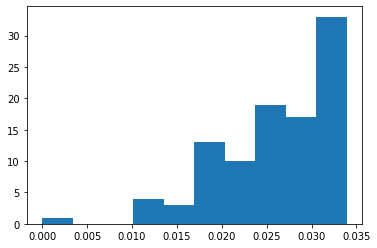

catalytic activity, acting on a tRNA
['trans-hexaprenyltranstransferase activity', 'lipoprotein particle receptor activity', 'regulation of digestive system process', 'nuclear membrane fusion involved in karyogamy', 'negative regulation by organism of entry into cell of other organism via phagocytosis involved in symbiotic interaction', 'response to vitamin K', 'positive regulation of steroid biosynthetic process', 'ferredoxin-nitrate reductase activity', 'intrinsic component of organelle membrane', 'mitotic telomere tethering at nuclear periphery', 'histone H4-R3 demethylation', 'positive regulation of neuron differentiation', 'guanylate cyclase regulator activity', 'L-methionine salvage from methionine sulphoxide', 'N-(5-amino-5-carboxypentanoyl)-L-cysteinyl-D-valine synthase activity', 'Set3 complex', 'positive regulation of RNA interference', 'regulation of Wnt signaling pathway involved in dorsal/ventral axis specification', 'regulation of purine nucleotide biosynthetic process', 

In [77]:

dist, ind = tree.query(  embedmat[ index[go2id('GO:0000010')] ].reshape(1,-1) , k=100)

plt.hist(dist.ravel())
plt.show()

print( obo[ id2GO(int(reverse_index[go2id('GO:0000010')]))].name  )
print([ obo[ id2GO(int(reverse_index[Id]))].name for Id in list(ind[0])  if  id2GO(int(reverse_index[Id])) in obo] )


In [78]:
print(obo['GO:0000002'].name)
go = obo['GO:0000002']
print( get_ancestors([go.id] , obo ) )

mitochondrial genome maintenance
[6996, 7005, 9987, 71840, 2, 16043]


GO:0048235	level-03	depth-04	pollen sperm cell differentiation [biological_process]
returned terms
[[22198 21644 21642 21643 21640 21641 21638 21633 21639 21632 21636 31414
  31413 21635 31422 31412 21634 21637 31417 21630 21631 31415 31419 31423
  24181 31424 31418 31425 22865 22869 24178 31420 24184 31421 24185 24179
  22195 24183 22867 21728 31416 22868 22866 22870 24180 22197 22196 24182
  21852 22871]]


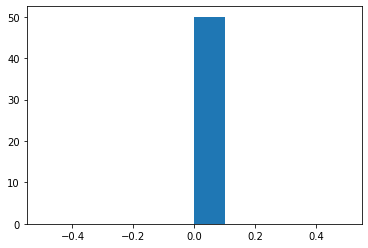

['complement-mediated synapse pruning', '1-alkylglycerophosphocholine O-acyltransferase activity', 'prepulse inhibition', '1-alkenylglycerophosphocholine O-acyltransferase activity', 'regulation of catecholamine metabolic process', 'flotillin complex', 'TERT-RMRP complex', 'double-stranded RNA biosynthetic process', 'regulation of dopamine metabolic process', 'negative regulation of production of siRNA involved in RNA interference', 'negative regulation of RNA interference', 'seed trichome elongation', 'seed trichome initiation', 'positive regulation of nitric-oxide synthase activity', 'cyanidin 3-O-glucoside biosynthetic process', 'negative regulation of vernalization response', 'replicative senescence', 'template-free RNA nucleotidyltransferase', 'middle lamella', 'neural plate mediolateral regionalization', 'positive regulation of monooxygenase activity', 'secondary cell wall biogenesis involved in seed trichome differentiation', 'trihydroxystilbene synthase activity', '(13E)-labda-

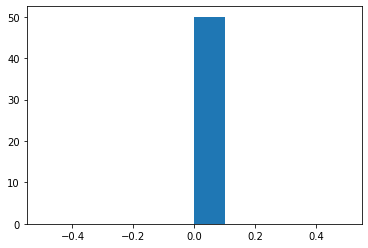

['complement-mediated synapse pruning', '1-alkylglycerophosphocholine O-acyltransferase activity', 'prepulse inhibition', '1-alkenylglycerophosphocholine O-acyltransferase activity', 'regulation of catecholamine metabolic process', 'flotillin complex', 'TERT-RMRP complex', 'double-stranded RNA biosynthetic process', 'regulation of dopamine metabolic process', 'negative regulation of production of siRNA involved in RNA interference', 'negative regulation of RNA interference', 'seed trichome elongation', 'seed trichome initiation', 'positive regulation of nitric-oxide synthase activity', 'cyanidin 3-O-glucoside biosynthetic process', 'negative regulation of vernalization response', 'replicative senescence', 'template-free RNA nucleotidyltransferase', 'middle lamella', 'neural plate mediolateral regionalization', 'positive regulation of monooxygenase activity', 'secondary cell wall biogenesis involved in seed trichome differentiation', 'trihydroxystilbene synthase activity', '(13E)-labda-

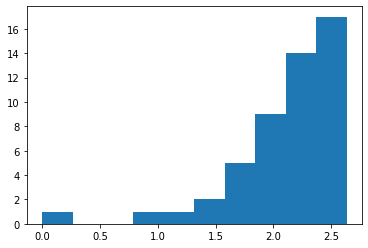

['binding', 'identical protein binding', 'protein binding', 'proteolysis', 'protein metabolic process', 'phosphatase activity', 'metal cluster binding', 'zinc ion binding', 'cell death', 'nitrogen compound metabolic process', 'hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds', 'oxidoreductase activity, acting on the aldehyde or oxo group of donors', 'hydrolase activity, acting on ester bonds', 'transition metal ion binding', 'carboxylic acid biosynthetic process', 'FAD binding', 'pyrophosphatase activity', 'interspecies interaction between organisms', 'glucose metabolic process', 'extracellular region', 'photosynthetic membrane', 'cellular protein modification process', 'nucleoside-triphosphatase activity', 'hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in linear amides', '4 iron, 4 sulfur cluster binding', 'alditol metabolic process', 'ion transport', 'sulfur amino acid biosynthetic process', 'catalytic activity, acting on a protein', 'fla

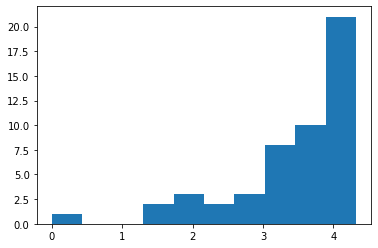

['plasma membrane', 'integral component of membrane', 'cytosol', 'membrane', 'cation binding', 'cytoplasm', 'ATP binding', 'purine ribonucleoside triphosphate binding', 'intrinsic component of membrane', 'cellular anatomical entity', 'nucleotide binding', 'small molecule binding', '4 iron, 4 sulfur cluster binding', 'iron-sulfur cluster binding', 'metal ion binding', 'hydrolase activity', 'cofactor binding', 'adenyl ribonucleotide binding', 'transferase activity', 'quinone biosynthetic process', 'drug binding', 'nitrogen compound metabolic process', 'anion binding', 'response to chemical', 'hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in linear amides', 'intrinsic component of plasma membrane', 'lyase activity', 'integral component of plasma membrane', 'isomerase activity', 'molecular_function', 'binding', 'cellular metabolic process', 'metabolic process', 'transmembrane transport', 'nucleoside phosphate binding', 'transport', 'carboxylic acid biosynthetic pro

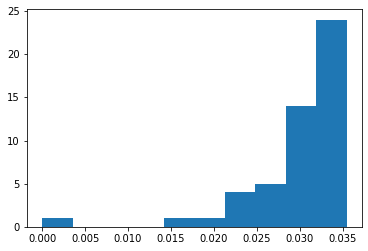

['sexual reproduction', 'Golgi lumen', 'actomyosin contractile ring maintenance', 'melatonin receptor activity', 'negative regulation of transferase activity', 'G protein-coupled serotonin receptor activity', 'positive regulation of cytokinesis, actomyosin contractile ring assembly', 'RNA import into nucleus', 'calcium-dependent protein serine/threonine kinase activity', 'steryl deacetylase activity', 'regulation of mitochondrial depolarization', 'positive regulation of lung ciliated cell differentiation', 'negative regulation of SMAD protein complex assembly', 'mammary gland epithelial cell differentiation', 'cortical microtubule cytoskeleton', 'lung alveolus development', 'eukaryotic 48S preinitiation complex', 'pronephric distal tubule development', 'secondary neural tube formation', 'positive regulation of mitotic spindle organization', 'anaerobic respiration, using ammonium as electron donor', 'positive regulation of protein deacetylation', 'growing cell tip', 'embryonic retina mo

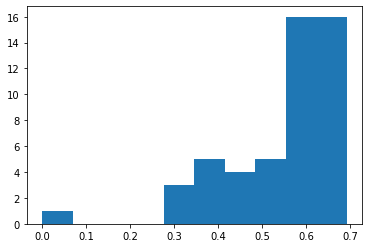

['organelle membrane', 'stress response to metal ion', 'stress response to copper ion', 'beta-alanine biosynthetic process', 'mannosylglycerate metabolic process', '5-carboxymethyl-2-hydroxymuconic-semialdehyde dehydrogenase activity', 'mannosylglycerate biosynthetic process', 'maleylacetate reductase activity', 'positive regulation of oxidoreductase activity', 'regulation of lipid metabolic process', 'mannosyl-3-phosphoglycerate phosphatase activity', 'vacuole', 'response to herbicide', 'glycerate 2-kinase activity', 'pyridoxal 4-dehydrogenase activity', 'CAAX-box protein processing', 'isocitrate dehydrogenase (NAD+) activity', 'indolepyruvate ferredoxin oxidoreductase activity', 'cytochrome-c3 hydrogenase activity', '2-deoxyglucose-6-phosphatase activity', 'response to hydroperoxide', '6-sulfoquinovose(1-) catabolic process to glycerone phosphate and 3-sulfolactaldehyde', 'L-iditol 2-dehydrogenase activity', 'regulation of purine nucleobase metabolic process', 'cellular response to n

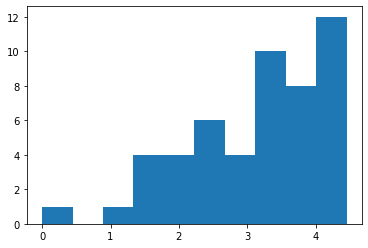

['integral component of membrane', 'cytosol', 'membrane', 'plasma membrane', 'cation binding', 'intrinsic component of membrane', 'nucleotide binding', 'purine ribonucleoside triphosphate binding', 'ATP binding', 'cytoplasm', 'small molecule binding', 'metal ion binding', 'anion binding', 'drug binding', 'cellular anatomical entity', 'lyase activity', 'molecular_function', 'adenyl ribonucleotide binding', 'hydrolase activity', 'cofactor binding', 'transferase activity', 'coenzyme binding', 'isomerase activity', 'response to chemical', 'iron-sulfur cluster binding', 'nucleoside phosphate binding', 'nitrogen compound metabolic process', '4 iron, 4 sulfur cluster binding', 'metabolic process', 'cellular metabolic process', 'hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in linear amides', 'transferase activity, transferring phosphorus-containing groups', 'phosphate-containing compound metabolic process', 'oxidation-reduction process', 'oxidoreductase activity', 'ox

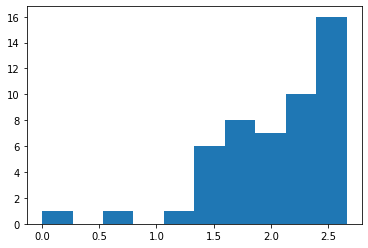

['integral component of plasma membrane', 'intrinsic component of plasma membrane', 'ATPase activity', 'protein-containing complex', 'nucleoside-triphosphatase activity', 'acid-thiol ligase activity', 'cellular macromolecule biosynthetic process', 'catalytic activity, acting on a protein', 'heterocyclic compound binding', 'cellular protein metabolic process', 'pathogenesis', '4 iron, 4 sulfur cluster binding', 'transport', 'arginine metabolic process', 'organic cyclic compound binding', 'glutamine family amino acid metabolic process', 'interspecies interaction between organisms', 'arginine biosynthetic process', 'DNA binding', 'peptide biosynthetic process', 'proteolysis', 'translation', 'transmembrane transport', 'membrane protein complex', 'quinone biosynthetic process', 'protein metabolic process', 'ATPase-coupled transmembrane transporter activity', 'transmembrane transporter activity', 'ion transport', 'regulation of gene expression', 'regulation of cellular macromolecule biosynth

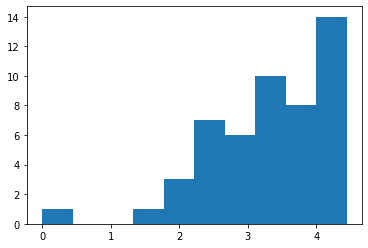

['intrinsic component of membrane', 'integral component of membrane', 'drug binding', 'membrane', 'cytosol', 'nucleotide binding', 'cation binding', 'metal ion binding', 'small molecule binding', 'purine ribonucleoside triphosphate binding', 'ATP binding', 'anion binding', 'isomerase activity', 'cofactor binding', 'plasma membrane', 'lyase activity', 'iron-sulfur cluster binding', 'cytoplasm', 'oxidation-reduction process', 'adenyl ribonucleotide binding', 'hydrolase activity', 'response to chemical', 'oxidoreductase activity', 'hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in linear amides', 'cellular anatomical entity', 'coenzyme binding', 'nucleoside phosphate binding', 'oxidoreductase activity, acting on CH-OH group of donors', 'oxidoreductase activity, acting on the CH-OH group of donors, NAD or NADP as acceptor', 'metabolic process', '4 iron, 4 sulfur cluster binding', 'nitrogen compound metabolic process', 'transferase activity', 'cellular metabolic proc

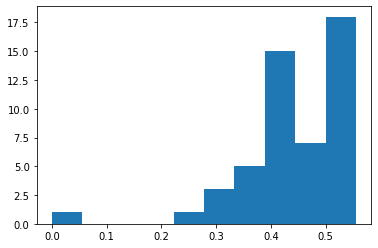

['membrane-bounded organelle', 'disruption by virus of host cell', 'estradiol 17-beta-dehydrogenase activity', 'protein N-acetylglucosaminyltransferase complex', 'positive regulation of growth', 'sulfur oxidation', 'microtubule binding', 'archaetidylserine synthase activity', 'box H/ACA snoRNP complex', '2-hydroxychromene-2-carboxylate isomerase activity', 'mannitol dehydrogenase activity', 'bacteriocin transmembrane transporter activity', 'mitochondrion', 'pyrrolysine biosynthetic process', 'decarboxylation-driven active transmembrane transporter activity', 'NEDD8-specific protease activity', 'host cell', 'formate catabolic process', 'protein modification by small protein conjugation or removal', 'cytosolic tRNA wobble base thiouridylase complex', 'oligosaccharyl transferase activity', 'snRNA pseudouridine synthesis', 'retinal metabolic process', 'box H/ACA snoRNA processing', 'phenol 2-monooxygenase activity', 'N-acetylglucosamine-6-sulfatase activity', 'tubulin binding', 'long-chain

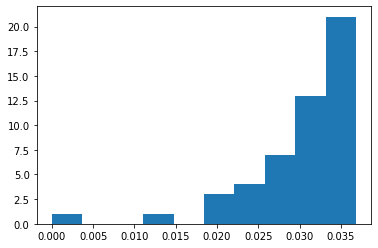

['reproduction', "mRNA 3'-UTR AU-rich region binding", 'carnitine metabolic process, CoA-linked', 'in utero embryonic development', 'nucleus organization', 'pancreas development', 'cell wall beta-glucan biosynthetic process', 'mitochondrial RNA catabolic process', 'cytosolic transport', 'delamination', 'type B pancreatic cell development', 'phagosome reneutralization', 'negative regulation of septation initiation signaling', 'dehydro-D-arabinono-1,4-lactone metabolic process', 'negative regulation of protein localization to membrane', 'negative regulation of sphingolipid biosynthetic process', 'positive regulation of fatty acid oxidation', 'regulation of DNA strand resection involved in replication fork processing', 'regulation of mitotic division septum assembly', 'piecemeal microautophagy of the nucleus', 'P granule organization', 'negative regulation of cytoskeleton organization', 'acid sphingomyelin phosphodiesterase activity', 'GDP-4-dehydro-D-rhamnose reductase activity', 'type I

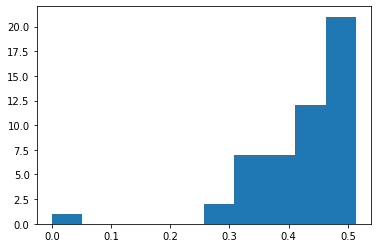

['membrane fusion', 'regulation of RNA helicase activity', 'inner mitochondrial membrane organization', 'Golgi-associated vesicle', 'polyhedral organelle', 'bacterial-type RNA polymerase holo enzyme binding', 'vitamin B6 transport', 'intrinsic component of mitochondrial membrane', 'transcription elongation from bacterial-type RNA polymerase promoter', 'positive regulation of nitric oxide biosynthetic process', 'guanine transmembrane transport', 'negative regulation of mitochondrial translation', 'metabolism by symbiont of host protein', 'positive regulation of filopodium assembly', 'pyridine nucleoside metabolic process', 'protein-disulfide reductase (glutathione) activity', 'filamentous growth of a population of unicellular organisms', 'leukocyte adhesion to vascular endothelial cell', 'cellular response to cell envelope stress', 'glucose:proton symporter activity', 'nuclear chromosome segregation', 'apical plasma membrane', 'Pip2-Oaf1 complex', 'anchored component of cell outer membr

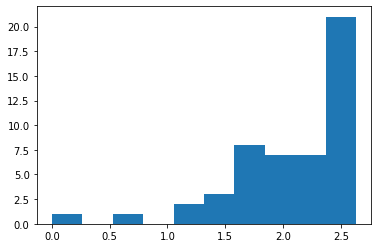

['intrinsic component of plasma membrane', 'integral component of plasma membrane', 'ATPase activity', 'transport', 'pathogenesis', 'organic cyclic compound binding', 'heterocyclic compound binding', '4 iron, 4 sulfur cluster binding', 'transmembrane transport', 'catalytic activity, acting on a protein', 'cellular macromolecule biosynthetic process', 'quinone biosynthetic process', 'DNA binding', 'interspecies interaction between organisms', 'nucleoside-triphosphatase activity', 'acid-thiol ligase activity', 'arginine metabolic process', 'cellular protein metabolic process', 'endonuclease activity', 'transmembrane transporter activity', 'peptide biosynthetic process', 'translation', 'proteolysis', 'protein-containing complex', 'ATPase-coupled transmembrane transporter activity', 'glutamine family amino acid metabolic process', 'iron-sulfur cluster binding', 'nitrogen compound transport', 'organic substance transport', 'arginine biosynthetic process', 'ion transport', 'carbohydrate tran

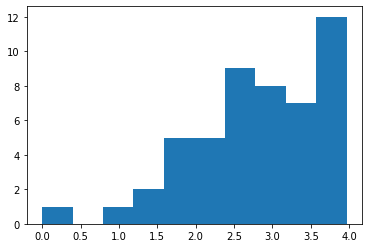

['membrane', 'cation binding', 'integral component of membrane', 'cytosol', 'nucleotide binding', 'purine ribonucleoside triphosphate binding', 'plasma membrane', 'cofactor binding', 'metal ion binding', 'intrinsic component of membrane', 'anion binding', 'hydrolase activity', 'ATP binding', 'small molecule binding', 'coenzyme binding', 'cytoplasm', 'drug binding', 'nitrogen compound metabolic process', 'iron-sulfur cluster binding', 'isomerase activity', 'response to chemical', 'adenyl ribonucleotide binding', 'hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in linear amides', 'cellular anatomical entity', 'cellular metabolic process', 'lyase activity', 'transition metal ion binding', 'nucleoside phosphate binding', '4 iron, 4 sulfur cluster binding', 'oxidoreductase activity, acting on CH-OH group of donors', 'carboxylic acid biosynthetic process', 'oxidation-reduction process', 'hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds', 'molecular

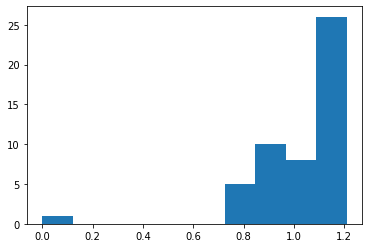

['membrane organization', 'erythritol kinase activity', 'D-alanyl carrier activity', '3-oxoadipate CoA-transferase activity', 'acryloyl-CoA reductase activity', 'beta-N-acetylglucosaminidase activity', 'catalytic activity, acting on a glycoprotein', 'levansucrase activity', 'teichoic acid D-alanylation', 'Gram-negative-bacterium-type cell wall biogenesis', 'positive regulation of protein transport', '3-hydroxyanthranilate 3,4-dioxygenase activity', 'glycopeptide alpha-N-acetylgalactosaminidase activity', '5-dehydro-2-deoxygluconokinase activity', 'lipopolysaccharide glucosyltransferase I activity', 'brassicasterol glucosyltransferase activity', 'collagen binding', 'phycocyanobilin:ferredoxin oxidoreductase activity', 'heparan sulfate proteoglycan biosynthetic process', 'catechol 2,3-dioxygenase activity', 'beta-1,4-mannosyltransferase activity', 'peptidoglycan-protein cross-linking', 'exo-1,4-beta-D-glucosaminidase activity', 'dihydroorotate dehydrogenase (fumarate) activity', 'aldehyd

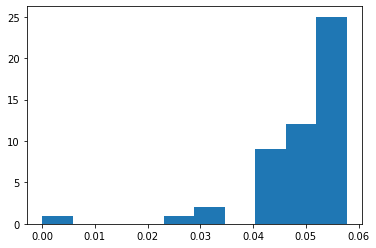

['organelle', 'vitamin E biosynthetic process', 'positive regulation of intracellular protein transport', 'nuclear localization sequence binding', 'response to disaccharide', 'ketohexokinase activity', 'DNA replication termination', 'response to fructose', 'cell cortex', 'inclusion body', 'positive regulation of DNA biosynthetic process', 'trans-2-enoyl-CoA reductase (NADPH) activity', 'regulation of blood pressure', 'microbody membrane', 'protein transmembrane import into intracellular organelle', 'regulation of cytoskeleton organization', 'cinnamic acid metabolic process', 'cGMP catabolic process', 'positive regulation of neuron migration', 'plasma membrane bounded cell projection', 'IgE binding', 'glutathione oxidoreductase activity', 'negative regulation of calcium ion transport into cytosol', 'peptidyl-L-cysteine S-palmitoylation', 'homologous recombination', 'carbon dioxide transmembrane transport', 'nucleus leading edge', 'digestion', 'single-species submerged biofilm formation'

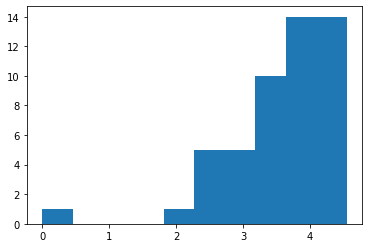

['molecular_function', 'lyase activity', 'nucleotide binding', 'anion binding', 'phosphate-containing compound metabolic process', 'transferase activity, transferring phosphorus-containing groups', 'purine ribonucleoside triphosphate binding', 'integral component of membrane', 'coenzyme binding', 'cytosol', 'carbohydrate metabolic process', 'adenyl ribonucleotide binding', 'small molecule binding', 'membrane', 'transferase activity, transferring acyl groups', 'primary metabolic process', 'cellular amino acid metabolic process', 'drug binding', 'nucleoside phosphate binding', 'response to chemical', 'ATP binding', 'cation binding', 'cellular biosynthetic process', 'hydrolase activity', 'organic substance metabolic process', 'cellular metabolic process', 'phosphorylation', 'nitrogen compound metabolic process', 'organonitrogen compound biosynthetic process', 'intrinsic component of membrane', 'metal ion binding', 'aromatic compound catabolic process', 'plasma membrane', 'kinase activity'

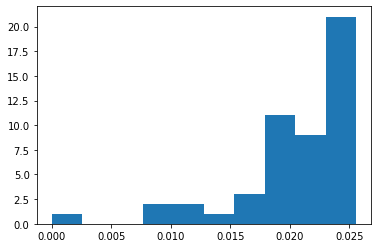

['fertilization', 'positive regulation of miRNA metabolic process', '3M complex', 'histone acetyltransferase activity (H4-K8 specific)', 'deoxyhypusine monooxygenase activity', 'positive regulation of acute inflammatory response to non-antigenic stimulus', 'regulation of microvillus organization', 'programmed cell death in response to reactive oxygen species', 'lysosome localization', 'detection of light stimulus involved in visual perception', 'negative regulation of DNA strand resection involved in replication fork processing', 'blasticidin-S deaminase activity', 'positive regulation of osteoblast differentiation', 'negative regulation of collateral sprouting of intact axon in response to injury', 'negative regulation of protein catabolic process in the vacuole', 'muscle cell development', 'negative regulation of core promoter binding', 'glial cell activation', 'nuclear rDNA heterochromatin', 'positive regulation of flocculation via cell wall protein-carbohydrate interaction by posit

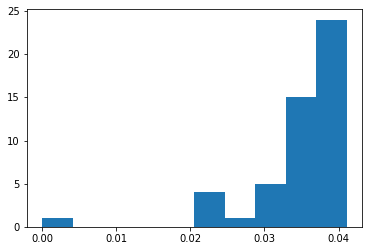

['developmental process involved in reproduction', 'inner ear morphogenesis', 'auditory receptor cell fate specification', 'glycogen binding', 'melanin-concentrating hormone activity', 'regulation of septation initiation signaling', 'positive regulation of sprouting angiogenesis', 'meiotic sister chromatid segregation', 'lymphocyte activation', 'artery development', 'protein phosphatase 2B binding', 'cerebellum morphogenesis', 'positive regulation of vasculature development', 'propanoate transport', 'regulation of protein localization to spindle pole body', 'positive regulation of androgen receptor activity', 'positive regulation of T cell mediated cytotoxicity', 'regulation of heart morphogenesis', 'regulation of spindle organization', 'NuA3 histone acetyltransferase complex', 'positive regulation of protein localization to kinetochore', 'cell trailing edge', 'positive regulation of cysteine-type endopeptidase activity', 'positive regulation of protein tyrosine phosphatase activity', 

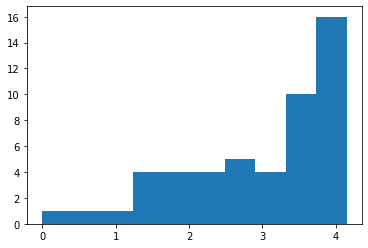

['developmental process', 'spore germination', 'bacillithiol metabolic process', 'arsenate ion transmembrane transporter activity', 'voltage-gated potassium channel complex', 'oxidoreductase activity, acting on a sulfur group of donors, iron-sulfur protein as acceptor', 'voltage-gated potassium channel activity', 'bacillithiol biosynthetic process', 'ATPase-coupled arsenite transmembrane transporter activity', 'nucleoside-triphosphatase regulator activity', 'GTPase regulator activity', "3',5'-cyclic-nucleotide phosphodiesterase activity", 'regulation of DNA metabolic process', 'heme a biosynthetic process', 'heme a metabolic process', 'potassium channel complex', "3',5'-cyclic-AMP phosphodiesterase activity", 'positive regulation of ion transmembrane transport', 'oxidoreductase activity, acting on the CH-NH group of donors, flavin as acceptor', 'sulfite reductase (ferredoxin) activity', 'molybdate ion transmembrane transporter activity', 'positive regulation of ion transmembrane transp

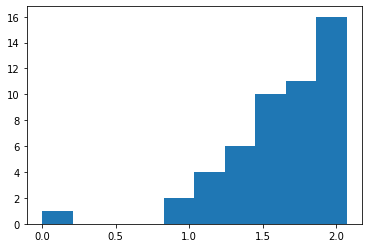

['biological_process', 'aromatic amino acid family metabolic process', 'intramolecular oxidoreductase activity', 'oxo-acid-lyase activity', 'racemase and epimerase activity, acting on carbohydrates and derivatives', 'purine nucleobase metabolic process', 'cellular amino acid catabolic process', 'purine-containing compound metabolic process', 'biosynthetic process', 'acid-amino acid ligase activity', 'protein transmembrane transport', 'organic cyclic compound biosynthetic process', 'phosphotransferase activity, alcohol group as acceptor', 'transferase activity, transferring hexosyl groups', 'division septum assembly', 'heterocycle biosynthetic process', 'cell septum assembly', 'drug catabolic process', 'UDP-glucosyltransferase activity', 'amidine-lyase activity', 'monosaccharide metabolic process', 'tryptophan metabolic process', 'phosphotransferase activity, carboxyl group as acceptor', 'phospholipid biosynthetic process', 'isoprenoid biosynthetic process', 'hexokinase activity', '2-ox

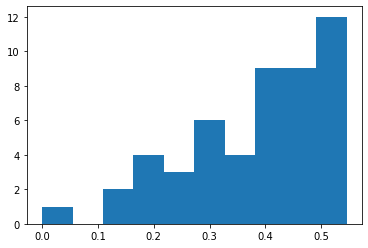

['intracellular membrane-bounded organelle', 'acyl-[acyl-carrier-protein]-phospholipid O-acyltransferase activity', 'serine-glyoxylate transaminase activity', 'retinoid metabolic process', 'translation regulator activity', 'polyphosphate:AMP phosphotransferase activity', 'transcription antitermination factor activity, RNA binding', 'regulation of nucleotide biosynthetic process', 'mitochondrial electron transport, NADH to ubiquinone', 'phosphonopyruvate decarboxylase activity', 'reductive iron assimilation', 'isoquinoline 1-oxidoreductase activity', 'thylakoid lumen', 'mRNA pseudouridine synthesis', 'purine nucleoside bisphosphate catabolic process', 'hexitol dehydrogenase activity', 'ribonucleoside bisphosphate catabolic process', 'positive regulation of phosphorylation', 'acetyl-CoA catabolic process', 'sedoheptulose-bisphosphatase activity', 'positive regulation of cell adhesion', 'acetylene hydratase activity', 'nitrate reductase (NADH) activity', 'negative regulation of multi-orga

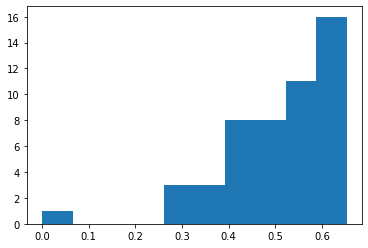

['cellular component organization', 'photosynthetic electron transport in photosystem I', 'positive regulation of phosphorylation', 'translation regulator activity', 'acyl-[acyl-carrier-protein]-phospholipid O-acyltransferase activity', 'serine-glyoxylate transaminase activity', 'thylakoid lumen', 'sedoheptulose-bisphosphatase activity', 'polyphosphate:AMP phosphotransferase activity', 'intracellular membrane-bounded organelle', 'purine nucleoside bisphosphate catabolic process', 'muconate cycloisomerase activity', 'nitrous-oxide reductase activity', 'ribonucleoside bisphosphate catabolic process', 'mitochondrial electron transport, NADH to ubiquinone', 'transcription antitermination factor activity, RNA binding', 'regulation of nucleotide biosynthetic process', 'phosphonopyruvate decarboxylase activity', 'bacteriocin transmembrane transporter activity', 'actin filament binding', 'reductive iron assimilation', 'circadian rhythm', 'acetyl-CoA catabolic process', 'hexitol dehydrogenase a

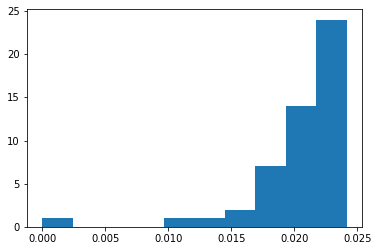

['plasma membrane fusion', 'microtubule plus end polymerase', 'hepatocyte growth factor receptor signaling pathway', 'MSL complex', 'amylin receptor signaling pathway', 'male meiosis chromosome separation', 'intraciliary transport involved in cilium assembly', 'endoplasmic reticulum tubular network', 'regulation of miRNA metabolic process', 'positive regulation of osteoblast proliferation', 'cyclase inhibitor activity', 'mitigation of host immune response by virus', 'cardiac muscle tissue development', 'KDEL sequence binding', 'regulation of proteasome assembly', 'positive regulation of natural killer cell mediated cytotoxicity directed against tumor cell target', '2-acylglycerol O-acyltransferase activity', 'regulation of postsynaptic specialization assembly', 'regulation of protein sumoylation', 'negative regulation of error-prone translesion synthesis', 'CMG complex', 'regulation of protein localization to cell tip', 'high voltage-gated calcium channel activity', 'nerve development'

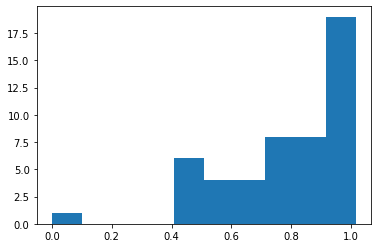

['lipid binding', 'ferric iron binding', 'propionate catabolic process, 2-methylcitrate cycle', 'aerobic electron transport chain', 'phosphoglucosamine mutase activity', 'NADH oxidation', 'propionate catabolic process', 'carotenoid dioxygenase activity', 'class I DNA-(apurinic or apyrimidinic site) endonuclease activity', 'FMN reductase activity', 'acylglycerol catabolic process', 'phosphoribosylglycinamide formyltransferase activity', 'phosphomannomutase activity', 'asparagine synthase (glutamine-hydrolyzing) activity', 'glutamate racemase activity', "guanosine-5'-triphosphate,3'-diphosphate diphosphatase activity", 'NADH metabolic process', 'zinc ion transmembrane transporter activity', 'terpene catabolic process', 'dTDP-rhamnose biosynthetic process', 'sulfate assimilation, phosphoadenylyl sulfate reduction by phosphoadenylyl-sulfate reductase (thioredoxin)', 'cellular response to organic cyclic compound', 'lysine-tRNA ligase activity', 'protein glycosylation', 'GMP biosynthetic pro

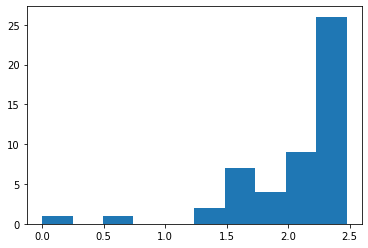

['cellular process', 'cell division', 'sulfur compound binding', 'carbon-carbon lyase activity', 'membrane protein complex', 'carbohydrate derivative metabolic process', 'menaquinone metabolic process', 'cobalamin biosynthetic process', 'menaquinone biosynthetic process', 'protein metabolic process', 'hexose metabolic process', 'cellular protein metabolic process', 'acid-thiol ligase activity', 'cobalamin metabolic process', 'water-soluble vitamin biosynthetic process', 'ligase activity', 'catalytic activity, acting on a protein', 'tetrapyrrole biosynthetic process', 'ligase activity, forming carbon-nitrogen bonds', 'organonitrogen compound metabolic process', 'photosynthetic membrane', 'protein-containing complex', 'catalytic complex', 'sulfur compound biosynthetic process', 'terpenoid biosynthetic process', 'hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in cyclic amides', 'cell death', 'peptide biosynthetic process', 'proteolysis', 'arginine biosynthetic proc

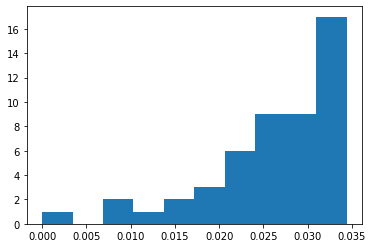

['cellular process involved in reproduction in multicellular organism', 'negative regulation of ossification', 'ADP-ribose pyrophosphohydrolase activity', 'eukaryotic translation elongation factor 1 complex', 'positive regulation of pyruvate dehydrogenase activity', '5S rDNA binding', 'phosphoglycerate phosphatase activity', 'N-alpha,N-alpha,N-alpha-trimethyl-L-histidine metabolic process', 'positive regulation of apoptotic signaling pathway', 'calcium-independent phospholipase A2 activity', 'positive regulation of mRNA splicing, via spliceosome', 'positive regulation of DNA-directed DNA polymerase activity', 'host cell endoplasmic reticulum membrane', 'long-chain fatty acid import into peroxisome', 'regulation of receptor-mediated endocytosis', 'phosphatidic acid transfer activity', 'negative regulation of spindle checkpoint', 'regulation of synaptic activity', 'eukaryotic translation initiation factor 3 complex, eIF3e', 'presynaptic membrane', 'positive regulation of myeloid leukocyt

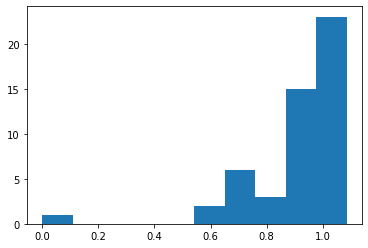

['multi-organism process', 'snoRNA polyadenylation', 'negative regulation of mRNA catabolic process', 'protein deglycation, glyoxal removal', 'DNA insertion or deletion binding', '(R)-carnitine:4-(trimethylammonio)butanoate antiporter activity', 'mammillary body development', 'regulation of mating-type specific transcription, DNA-templated', 'neurotransmitter receptor transport, postsynaptic endosome to lysosome', 'nucleoplasm', 'asexual sporulation resulting in formation of a cellular spore', 'phosphatidylinositol-4,5-bisphosphate phosphatase activity', 'decaprenyl-N-acetyl-alpha-D-glucosaminyl-pyrophosphate:dTDP-alpha-L-rhamnose rhamnosyltransferase activity', 'positive regulation of proteolysis', 'positive regulation of extrinsic apoptotic signaling pathway', 'SUMO polymer binding', 'mesenchyme migration', 'dGDP phosphorylation', 'positive regulation of single-species biofilm formation on inanimate substrate', 'mannoprotein biosynthetic process', 'histone deacetylase binding', 'vita

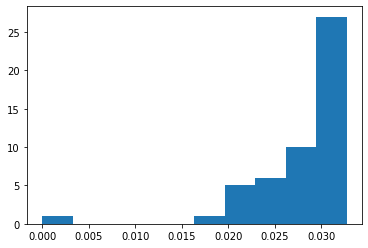

['multi-organism reproductive process', 'negative regulation of protein import into nucleus during spindle assembly checkpoint', 'mitochondrial membrane organization', 'ubiquitin-like protein conjugating enzyme activity', 'regulation of T cell differentiation', 'embryonic hemopoiesis', 'Atg8 ligase activity', 'regulation of glial cell proliferation', 'regulation of circadian sleep/wake cycle, sleep', 'response to fluid shear stress', 'positive regulation of insulin-like growth factor receptor signaling pathway', 'nuclear-transcribed mRNA catabolic process, nonsense-mediated decay', 'microfilament motor activity', 'myo-inositol transmembrane transporter activity', 'isocitrate dehydrogenase complex (NAD+)', 'negative regulation of cold-induced thermogenesis', 'negative regulation of dendrite extension', 'outward rectifier potassium channel activity', 'negative regulation of posttranscriptional gene silencing', 'extrinsic component of endoplasmic reticulum membrane', 'negative regulation 

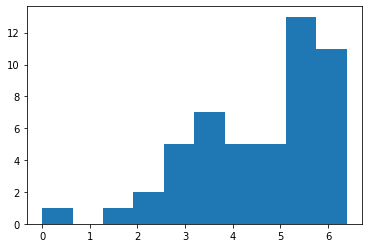

['cellular anatomical entity', 'cytoplasm', 'cation binding', 'metal ion binding', 'metabolic process', 'integral component of membrane', 'hydrolase activity', 'plasma membrane', 'membrane', 'cytosol', 'intrinsic component of membrane', 'oxidoreductase activity', 'oxidation-reduction process', 'transferase activity', 'catalytic activity', 'nucleotide binding', 'anion binding', 'purine ribonucleoside triphosphate binding', 'ATP binding', 'coenzyme binding', 'molecular_function', 'cofactor binding', 'small molecule binding', 'drug binding', 'lyase activity', 'isomerase activity', 'adenyl ribonucleotide binding', 'iron-sulfur cluster binding', 'cellular metabolic process', 'transition metal ion binding', 'nitrogen compound metabolic process', 'response to chemical', 'nucleoside phosphate binding', 'hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds', '4 iron, 4 sulfur cluster binding', 'hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in linear ami

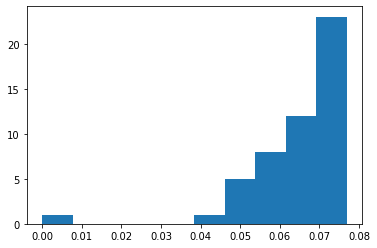

['cellular developmental process', 'acetylserotonin O-methyltransferase activity', 'response to fructose', 'exocytic vesicle', 'phosphatidylinositol phosphate 5-phosphatase activity', 'multi-organism metabolic process', 'positive regulation of potassium ion transport', 'cellular component assembly involved in morphogenesis', 'phagosome maturation', 'extracellular membrane-bounded organelle', 'oligoxyloglucan reducing-end-specific cellobiohydrolase activity', 'prostanoid biosynthetic process', 'phosphatidylcholine-sterol O-acyltransferase activity', 'actin cortical patch', 'regulation of cytoskeleton organization', 'double-strand break repair via break-induced replication', 'mitochondrial proton-transporting ATP synthase complex, catalytic core F(1)', '4-amino-4-deoxy-L-arabinose transferase activity', 'negative regulation of reductive pentose-phosphate cycle', 'spliceosomal snRNP assembly', 'supercoiled DNA binding', 'positive regulation of asexual reproduction', 'mating projection tip

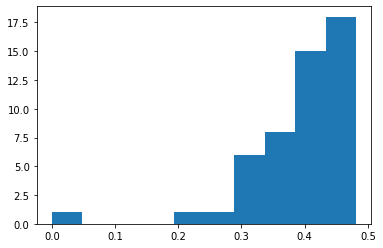

['single fertilization', 'regulation of carbohydrate biosynthetic process', 'sulfonate dioxygenase activity', 'mitochondrial proton-transporting ATP synthase, catalytic core', 'acylglycerone-phosphate reductase activity', 'sphingoid catabolic process', 'cholesterol import', 'polynucleotide phosphatase activity', 'regulation of organelle organization', 'gluconate 2-dehydrogenase (acceptor) activity', 'planar cell polarity pathway involved in gastrula mediolateral intercalation', 'mitigation of host defenses by symbiont', 'regulation of cell adhesion involved in single-species biofilm formation', 'ATPase-coupled organic acid transmembrane transporter activity', 'regulation of cellular ketone metabolic process', 'octopamine biosynthetic process', 'phthalyl amidase activity', 'cytidine transport', 'cortisol metabolic process', 'ferric-enterobactin transmembrane transporter activity', 'intermediate filament cytoskeleton', 'mitochondrial ribosome', 'death receptor activity', 'pyruvate second

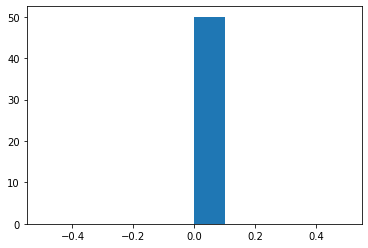

['complement-mediated synapse pruning', '1-alkylglycerophosphocholine O-acyltransferase activity', 'prepulse inhibition', '1-alkenylglycerophosphocholine O-acyltransferase activity', 'regulation of catecholamine metabolic process', 'flotillin complex', 'TERT-RMRP complex', 'double-stranded RNA biosynthetic process', 'regulation of dopamine metabolic process', 'negative regulation of production of siRNA involved in RNA interference', 'negative regulation of RNA interference', 'seed trichome elongation', 'seed trichome initiation', 'positive regulation of nitric-oxide synthase activity', 'cyanidin 3-O-glucoside biosynthetic process', 'negative regulation of vernalization response', 'replicative senescence', 'template-free RNA nucleotidyltransferase', 'middle lamella', 'neural plate mediolateral regionalization', 'positive regulation of monooxygenase activity', 'secondary cell wall biogenesis involved in seed trichome differentiation', 'trihydroxystilbene synthase activity', '(13E)-labda-

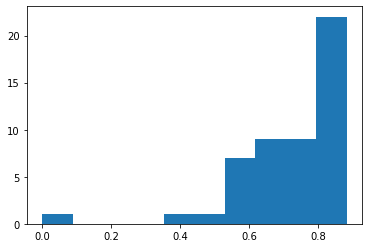

['intracellular organelle', 'magnesium protoporphyrin IX methyltransferase activity', 'actin filament binding', 'phenylalanine racemase (ATP-hydrolyzing) activity', '2-hydroxy-3-keto-5-methylthiopentenyl-1-phosphate phosphatase activity', 'L-methylmalonyl-CoA metabolic process', 'glycerol-1-phosphate dehydrogenase [NAD(P)+] activity', 'actin filament organization', 'geranylgeranyl reductase activity', 'glucose binding', 'photosynthetic electron transport in photosystem I', 'nitrous-oxide reductase activity', 'acireductone synthase activity', 'L-phenylalanine biosynthetic process from chorismate via phenylpyruvate', 'methyl indole-3-acetate esterase activity', 'mitigation of host immune response', 'thylakoid lumen', 'cellular response to phosphate starvation', 'chloramphenicol O-acetyltransferase activity', 'serine-glyoxylate transaminase activity', 'cytochrome o ubiquinol oxidase activity', 'cellulose biosynthetic process', 'glucose-6-phosphate 1-epimerase activity', 'dihydropyrimidine

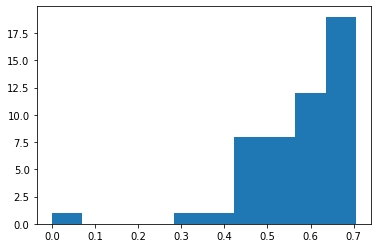

['cell differentiation', 'sulfide oxidation', 'cellular response to hypoxia', 'protein dealkylation', 'asparagine-tRNA ligase activity', 'formate dehydrogenase (cytochrome-c-553) activity', 'oxidoreductase activity, acting on the aldehyde or oxo group of donors, cytochrome as acceptor', 'ethanolamine ammonia-lyase complex', 'regulation of protein transport', 'fructose 6-phosphate aldolase activity', 'galactitol transport', 'cellular response to decreased oxygen levels', 'trehalose metabolism in response to stress', 'cellular monovalent inorganic cation homeostasis', 'protein demethylation', 'methylamine metabolic process', 'crotonobetaine-CoA ligase activity', 'protein ADP-ribosylation', 'antimonite transport', 'response to cAMP', 'carnitine-CoA ligase activity', 'protein-glutamate O-methyltransferase activity', 'cysteine export across plasma membrane', 'L-arabinose transmembrane transporter activity', 'oxidoreductase activity, acting on a heme group of donors', 'response to acid chemi

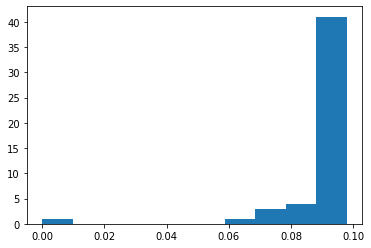

['endoplasmic reticulum', 'stress-activated protein kinase signaling cascade', 'positive regulation of gliogenesis', 'cell-cell junction', 'cell cycle DNA replication', 'RNA polymerase II CTD heptapeptide repeat kinase activity', 'positive regulation of G2/M transition of mitotic cell cycle', 'mitochondrial respirasome', 'guanosine-containing compound catabolic process', 'Golgi membrane', 'RNA polymerase II transcription factor binding', 'transmembrane receptor protein tyrosine kinase signaling pathway', 'cellular response to peptidoglycan', 'mitotic recombination', 'embryonic eye morphogenesis', 'striated muscle cell differentiation', 'steroid hormone receptor activity', 'Elg1 RFC-like complex', '15-oxoprostaglandin 13-oxidase activity', 'intracellular', 'antigen receptor-mediated signaling pathway', 'positive regulation of cell communication', 'lamellipodium', 'DNA excision', 'tumor necrosis factor binding', 'postsynaptic specialization', 'associative learning', 'telomere maintenance

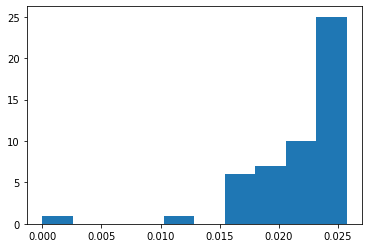

['cellular component organization or biogenesis', 'mitotic spindle midzone assembly', 'enone reductase activity', 'DH domain binding', 'heparin biosynthetic process', 'cellobiose dehydrogenase (acceptor) activity', 'intrinsic component of postsynaptic membrane', 'positive regulation of natural killer cell activation', 'hexuronate transmembrane transport', 'interleukin-11-mediated signaling pathway', 'D-leucyl-tRNA(Leu) deacylase activity', 'hemoglobin complex', 'N-box binding', 'snRNA transcription by RNA polymerase III', 'protein poly-ADP-ribosylation', 'transcription coactivator binding', 'volume-sensitive chloride channel activity', 'negative regulation of sister chromatid cohesion', 'phosphatidylinositol 3-kinase complex, class III', '2,4-diaminopentanoate dehydrogenase activity', 'regulation of telomere maintenance', 'regulation of cardiac muscle cell action potential involved in regulation of contraction', 'neural tube development', 'spliceosomal conformational changes to generat

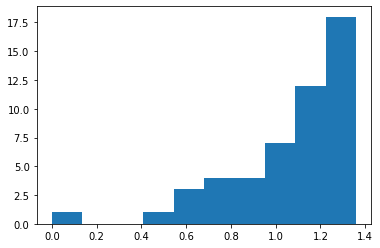

['cellular_component', 'protein processing', 'L-methionine salvage from methylthioadenosine', 'leucine metabolic process', 'energy coupled proton transmembrane transport, against electrochemical gradient', 'threonine metabolic process', 'electron transport coupled proton transport', 'amino acid binding', 'monosaccharide binding', 'heterocycle metabolic process', 'cellular iron ion homeostasis', 'cellular response to starvation', 'peptidase activity, acting on L-amino acid peptides', 'DNA-(apurinic or apyrimidinic site) endonuclease activity', 'mismatched DNA binding', 'C-acetyltransferase activity', 'sulfur compound catabolic process', 'cofactor transport', 'phosphotransferase activity, paired acceptors', 'cobalamin binding', 'aldehyde biosynthetic process', 'ammonia ligase activity', 'nucleoside salvage', 'outer membrane', 'transition metal ion transport', 'biotin metabolic process', 'diaminopimelate metabolic process', 'sugar-phosphatase activity', 'racemase activity, acting on amino

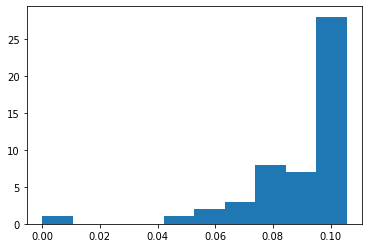

['endoplasmic reticulum membrane', 'peptidyl-proline 4-dioxygenase activity', 'fatty acid alpha-oxidation', 'glycerophosphoinositol glycerophosphodiesterase activity', 'symbiont-containing vacuole', 'cellular response to calcium ion', 'uridine metabolic process', "bis(5'-adenosyl)-triphosphatase activity", 'regulation of neurotransmitter secretion', 'inorganic cation import across plasma membrane', 'cellular response to nitrogen starvation', 'organellar large ribosomal subunit', 'procollagen-proline dioxygenase activity', 'galactose oxidase activity', 'type V protein secretion system complex', 'multicellular organism development', 'negative regulation of cellular response to drug', 'sterol import', 'deoxycytidine kinase activity', 'filamentous growth', 'cysteine-type endopeptidase inhibitor activity', 'D-serine biosynthetic process', 'phosphatidylinositol phosphate 5-phosphatase activity', 'plastid envelope', 'phenylpyruvate tautomerase activity', 'cellular response to nitrogen levels'

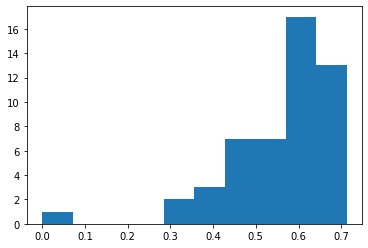

['reproductive process', 'maintenance of location in cell', 'fatty alcohol metabolic process', 'ceramide metabolic process', 'imidazoleglycerol-phosphate synthase activity', 'diaminobutyrate-2-oxoglutarate transaminase activity', 'linear malto-oligosaccharide phosphorylase activity', 'copper ion transmembrane transport', 'glycine oxidase activity', 'oxidoreductase activity, acting on phosphorus or arsenic in donors, disulfide as acceptor', 'arsenate reductase (glutaredoxin) activity', 'carbamoyl-phosphate synthase (ammonia) activity', 'copper ion export', 'malate synthase activity', 'starch binding', '6-carboxy-5,6,7,8-tetrahydropterin synthase activity', 'oxidoreductase activity, acting on the aldehyde or oxo group of donors, with a quinone or similar compound as acceptor', 'L-isoleucine transaminase activity', 'short-chain carboxylesterase activity', 'hydroxymethylglutaryl-CoA reductase (NADPH) activity', 'phytol metabolic process', 'aspartate oxidase activity', 'phosphopyruvate hydr

In [79]:
import random


#print( get_ancestors( [ id2GO(g) for g in godict['479378']], obo) )


for i in range(govecs['479378'].shape[0]):
    print( obo[goa.id2goterm( godict['479378'][i] )])
    dist, ind = tree.query( govecs['479378'][i] , k=50)    
    print('returned terms')
    #print(obo[list(godict['HOG:0479378'])[i]].name)
    print(ind)
    plt.hist(dist.ravel())
    plt.show()
    print([ obo[ id2GO(int(reverse_index[Id]))].name for Id in list(ind[0]) if  id2GO(int(reverse_index[Id])) in obo]  )

    

In [72]:
#free up the gpu
del embedder

2290
159.10817542394003


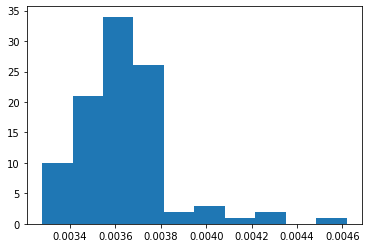

In [33]:
#create a normalized taxonomy embedding for a species aware classifier
print( len ( [ l for l in p.tree.get_leaves() ]))
import time
leaves = [ l for l in p.tree.get_leaves() ]
import random

times =[]
for i in range(100):
    t = time.time()
    p.tree.get_distance(random.choice(leaves).name,random.choice(leaves).name, topology_only=True)
    times.append(time.time()-t)
plt.hist(times)
print( np.mean(times)*(2290**2 / 2 - 2290) / 60 )



In [34]:

import multiprocessing as mp
from functools import partial

pool = mp.Pool()
distances = [ (l1.name,l2.name ) for i,l1 in enumerate(p.tree.get_leaves()) for j,l2 in enumerate(p.tree.get_leaves()) if i < j  ]
indices = [ (i,j )   for i,l1 in enumerate(p.tree.get_leaves()) for j,l2 in enumerate(p.tree.get_leaves()) if i < j  ]

def treedist( ltuple , tree):
    return tree.get_distance( ltuple[0] , ltuple[1], topology_only = True)

nleaves = len([ l for l in p.tree.get_leaves() ] )
treedist_load = partial( treedist , tree= p.tree )
res = pool.map_async(   treedist_load , distances ).get()

del pool

Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  F

KeyboardInterrupt: 

  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
taxmat = np.zeros( (nleaves, nleaves) )
for i,index in enumerate(indices):
    taxmat[index] = res[i]
taxmat+=taxmat.T

print(taxmat)
plt.hist(taxmat.ravel())
plt.show()
with open( 'taxkernel.pkl' ,'wb')as taxkernelout:
    taxkernelout.write(pickle.dumps(distances))
#project down with mds

In [ ]:
from sklearn.manifold import MDS
#create taxonomy projection
mds = MDS( n_components = 2 )
taxembed = mds.fit_transform(taxmat)
with open( 'taxproj.pkl' , 'wb') as taxprojout:
    taxprojout.write( pickle.dumps(taxembed))

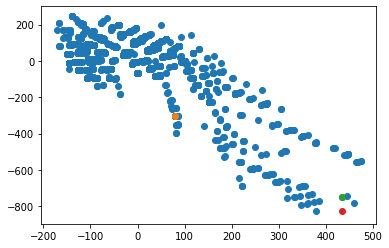

In [35]:
with open( 'taxproj.pkl' , 'rb' ) as taxprojin :
    taxembed = pickle.loads( taxprojin.read())
    
#use the profiler trimmed ncbi tree to generate an index 
taxindex = {int( n.name ) : i for i,n in enumerate( p.tree.get_leaves() ) }

plt.scatter( taxembed[:,0], taxembed[:,1]  )
#where is arabidopsis
plt.scatter( taxembed[taxindex[3702],0] , taxembed[taxindex[3702],1])
#where is human
plt.scatter( taxembed[taxindex[9606],0] , taxembed[taxindex[9606],1])
#where is chimp
plt.scatter( taxembed[taxindex[9606],0] , taxembed[taxindex[9598],1])
plt.show()
#ok... this more or less works


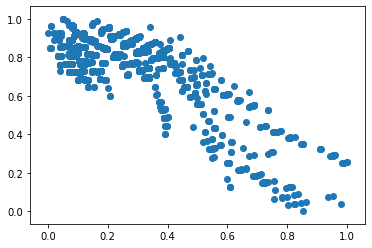

In [36]:
from sklearn.preprocessing import RobustScaler , MinMaxScaler
rs = MinMaxScaler()
taxembedscaled = rs.fit_transform( taxembed )
plt.scatter( taxembedscaled[:,0], taxembedscaled[:,1]  )
plt.show()

In [37]:
embedmat_scaled = rs.fit_transform( embedmat )

In [90]:
from sklearn.cluster import AffinityPropagation
def profiler_naive( qhog , p , gaf , c , nannot , hogs,  k = 10 , verbose = True , ignoreqhog = True ):
    
    #use jaccard and IC to weigh all returned GO terms
    
    res = p.hog_query(fam_id = qhog , k = k )
    
    if len(res) == 0 :
        return None
    
    #grab entries from hogs
    hashes =  p.pull_hashes(res+[qhog])
    jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in res }
    members =  { r : [m for m in hogs[int(r)] if m in gaf ] for r in res  }
    godict = {  m + '_' + str(go) :{ 'fam':r , 'GO':go , 'Jaccard': jaccards[r] } for r in members for m in members[r] for go in get_ancestors( gaf[m] , obo )  }
    godf = pd.DataFrame.from_dict( godict , orient = 'index')
    ICs = { go:-np.log( c[go] / nannot ) for go in godf.GO.unique() if go in c }
    ICs.update( { go:max(ICs.values()) for go in godf.GO.unique() if go not in ICs }  )
    godf['IC'] = godf.GO.map(ICs)
    if ignoreqhog == True:
        godf = godf[ godf.fam != str(qhog) ]
        godf = godf[ godf.fam != qhog ]
    #calculate the jaccards relative to the query
    godf['jaccard'] = godf.fam.map(jaccards)
    #max jaccard * IC
    preddict = { go:{'max_jaccard':godf[godf.GO == go].jaccard.max() , 'IC':ICs[go] , 'coverage' : len( godf[godf.GO == go ]) / len(godf)  } for go in godf.GO.unique() if go in ICs }
    predDF = pd.DataFrame.from_dict( preddict , orient = 'index')
    #awesome master super scoring function goes here
    predDF['score'] =   (predDF.max_jaccard /  predDF.max_jaccard.max() )  * ( predDF.IC.min() /  predDF.IC ) * (predDF.coverage / predDF.coverage.max())
    
    #consequences be damned...
    return predDF


def embedding_kd_ap(qhog,  p, kdtree, embedmat , index , reverse_index , nannot, c , k  , nsuggestions , hogs , ignoreqhog = True):
    
    #use kdtree of go term embedding and profiler to grab suggestions
    #centroids of annotation clusters of all hogs returned are used to suggest k terms each
    #each cluster gets a jaccard score.
    #each annotation suggested gets distance from centroid. jaccard and IC
    res = p.hog_query(fam_id = qhog , k = k )
    
    if len(res) == 0 :
        return None
    #grab entries from hogs leaving qhog in there
    members =  { r : [m for m in hogs[int(r)] if m in gaf ] for r in res  }
    
    godict = {  m + '_' + str(go) :{ 'fam':r , 'GO':go } for r in members for m in members[r] for go in get_ancestors( gaf[m] , obo )  }
    godf = pd.DataFrame.from_dict( godict , orient = 'index')
    
    
    if len(godict) == 0:
        return None
    
    hashes =  p.pull_hashes(res + [qhog])
    jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in members }
    godf['jaccard'] = godf.fam.map(jaccards)
    if ignoreqhog == True:
        try:
            godf = godf[ godf.fam != qhog ]
            godf = godf[ godf.fam != str(qhog) ]
        except:
            return None
    
    
    #get the terms in embedding space    
    GO_embedding = [ index[go] for go in godf.GO.unique() if go in index]
    terms = np.array( godf.GO.unique() )
    #print(list( GO_embedding.values()))
    #calculate the jaccards relative to the query
    #AP into clusters
    
    
    govecs = embedmat[GO_embedding,:]
    af = AffinityPropagation().fit(np.vstack( govecs ) )
    #take cluster centroids
    #k suggestions per cluster centroid
    suggestions ={}
    for i,clustercenter in enumerate(af.cluster_centers_):
        
        subterms = terms[ np.where(af.labels_ == af.labels_[i] ) ]
        subdf = godf[godf.GO.isin(subterms)]
        
        dis,idx = tree.query( clustercenter.reshape(1, -1) , k=nsuggestions)
        #add distance to cluster center for suggestions
        #add small delta in case dist = 0
        
        suggestions.update( { reverse_index[matrow] : { 'distance': dis[0][j] +  10**-3 , 'cluster':i, 'jaccard':0 , 'nterms':len(subdf)  }  for j,matrow in enumerate(list(idx[0])) } )
    predDF = pd.DataFrame.from_dict(suggestions , orient = 'index')
    #precomput a numpy array and set the series in one go.
    jaccards = np.zeros( (len(predDF),1))
    nterms = np.zeros( (len(predDF),1))
    labels = np.array( predDF.cluster )

    subdfs = []
    
    
    for l in np.unique(af.labels_):
        #each label corresponds to a set of annotations in coevolving profiles        
        subterms = terms[ np.where(af.labels_ == l ) ]
        subdf = godf[godf.GO.isin(subterms)]
        jaccards[ np.where(labels == l ) ] = subdf.jaccard.max()
        nterms[np.where(labels == l )] = len(subdf)
        #mix in initial results
        subPred = pd.DataFrame.from_dict( { term : { 'distance': 10**-3  , 'cluster':i, 'jaccard':subdf.jaccard.max() , 'nterms':len(subdf)  }  for  term in list(subterms) }  , orient = 'index' ) 
        subdfs.append(subPred)
    
    predDF.jaccard = jaccards
    predDF.nterms = nterms
    subs = pd.concat(  subdfs ) 
    predDF = pd.concat( [ predDF, subs ])
    ICs = { go: -np.log( c[go] / nannot ) for go in predDF.index.unique() if go in c }
    ICs.update( { go:max(ICs.values()) for go in predDF.index.unique() if go not in ICs }  )
    
    
    predDF['IC'] = predDF.index.map(ICs)
    
    #awesome super scoring function goes here. maybe give the suggestions a bit less weight
    #predictions farther from the centroid get less weight
    #coev score influences the pred as well
    
    
    predDF.distance = predDF.distance - predDF.distance.min() + 1.1  
    predDF.distance = predDF.distance.map(lambda x : np.log(x))
 
    predDF['score'] =  (predDF.jaccard / predDF.jaccard.max()) * (  predDF.IC.min() / predDF.IC ) * ( predDF.distance.min() / predDF.distance )   *  ( predDF.nterms / predDF.nterms.max() ) 
    #predDF['name'] = predDF.index.map(lambda go : obo[ id2GO(go)].name )
    
    predDF = predDF[~predDF.score.isna()]

    #consequences be damned...
    
    return predDF




In [91]:
from sklearn.metrics import roc_curve , precision_recall_curve
from functools import partial
import random

nannot = sum(c.values())
nsamples = 2000
randoHogs =[ random.choice(list(hogs.keys())) for i in range( nsamples ) ]

In [ ]:
def prec_recall( randoHogs, profilerfun_partial , gaf , obo ):
    dfs = []
    t0 = time.time()
    
    for i,h in enumerate(randoHogs):
        predDF = profilerfun_partial(h)
        if i % 100 == 0 :
            print(i)
            print( time.time() -t0 )
            t0 = time.time()
        
        if predDF is not None:
            goset =  { go   for m in { m for m in hogs[int(h)]  if m in gaf } for go in get_ancestors( gaf[m] , obo )  }
            remainder = goset.difference( set(predDF.index ))
            remainderDF = pd.DataFrame.from_dict({ r : { c:0 for c in predDF.columns } for r in remainder} , orient = 'index')
            predDF = pd.concat([remainderDF,predDF])
            predDF['ytrue'] = predDF.index.map( lambda x : 1 if x in goset else 0 )
            dfs.append(predDF)
    
    finaldf = pd.concat(dfs)
    print(finaldf)
    precision, recall, thresholds = precision_recall_curve(finaldf.ytrue, finaldf.score)
    
    plt.figure( figsize = (20,20))
    plt.plot( recall , precision )
    plt.show()
    
    fpr, tpr, thresholds = roc_curve( finaldf.ytrue, finaldf.score )
    plt.figure( figsize = (20,20))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
    plt.show()
    
    plt.hist( finaldf.score[finaldf.ytrue == 1] , alpha = .5)
    plt.hist( finaldf.score[finaldf.ytrue == 0] , alpha = .5)
    plt.show()
         
    plt.hist( finaldf.score[finaldf.ytrue == 1] )
    plt.show()
    
    return finaldf


#profiler_naive_conf = partial(profiler_naive ,  p=p , gaf=gaf , c=c , nannot=nannot , hogs=hogs,  k = 20 , verbose = True , ignoreqhog = True  )
embedder_profiler = partial(embedding_kd_ap ,  p=p , kdtree=tree, embedmat=embedmat , index=index , reverse_index=reverse_index , nannot=nannot, c=c , k=20  , nsuggestions=15 , hogs=hogs , ignoreqhog = True)
#finaldf_naive = prec_recall( randoHogs , profiler_naive_conf , gaf , obo )
finaldf_embedder = prec_recall( randoHogs , embedder_profiler , gaf , obo )



0
0.004229307174682617
100
11.310845375061035
200
24.927695512771606
300
9.73534631729126
400
39.12387561798096
500
52.937161445617676
600
8.876962900161743
700
16.327547073364258
800
43.5253963470459
900
30.169965028762817
1000
13.269120216369629
1100
3.73168683052063
1200
45.207335472106934
1300
7.535656452178955
1400
9.899853944778442
1500
34.42212748527527
1600
35.55073165893555
1700
5.531958341598511
1800
12.701022148132324
1900
13.789937019348145


0.47902028810965436
0.18576953943146718


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


0.32674061741079874
0.1189688176116085


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


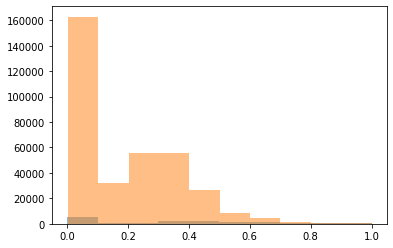

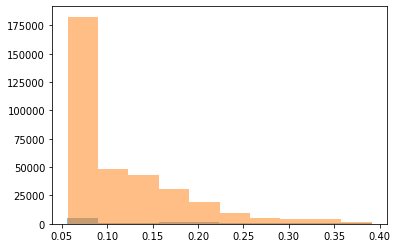

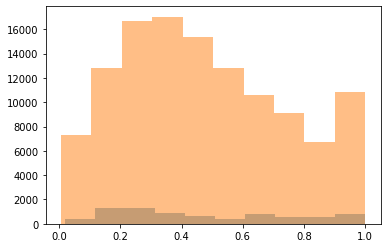

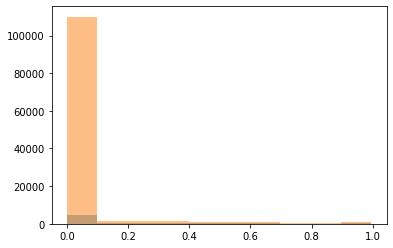

In [43]:
#todo. fit distribution to positive scores
from scipy.stats import norm
from scipy.stats import chi2



#just model the stupid things as multivariat gaussians and get a pval for each pred
filterfinal_naive = finaldf_naive[finaldf_naive.score > 0]
filterfinal_naive =  filterfinal_naive[ filterfinal_naive.ytrue == 1 ]
mean1 = filterfinal_naive.score.mean()
std1 = filterfinal_naive.score.std()
print(mean1)
print(std1)
finaldf_naive['proba_posi'] =  norm.cdf( finaldf_naive.score , loc=mean1, scale= std1 )
finaldf_naive['proba_posi'][finaldf_naive.score == 0 ] = 0 

filterfinal_naive = finaldf_naive[finaldf_naive.score > 0]
filterfinal_naive =  filterfinal_naive[ filterfinal_naive.ytrue == 0  ]
mean1 = filterfinal_naive.score.mean()
std1 = filterfinal_naive.score.std()
print(mean1)
print(std1)

finaldf_naive['proba_nega'] =  norm.cdf( finaldf_naive.score , loc=mean1, scale= std1 )
finaldf_naive['proba_nega'][finaldf_naive.score == 0 ] = 0 

finaldf_naive['likelihoodratio'] =  finaldf_naive.proba_posi / finaldf_naive.proba_nega

finaldf_naive['likelihoodratio'] =  finaldf_naive['likelihoodratio'].map( lambda x :-2* np.log(x) if x > 0 else 0 )



filterfinal_embedder= finaldf_embedder[finaldf_embedder.score > 0]
filterfinal_embedder=filterfinal_embedder[ filterfinal_embedder.ytrue == 1  ]
mean1 = filterfinal_embedder.score.mean()
std1 = filterfinal_embedder.score.std()
finaldf_embedder['proba_posi'] =  norm.cdf( finaldf_embedder.score , loc=mean1, scale= std1 )

filterfinal_embedder= finaldf_embedder[finaldf_embedder.score > 0]
filterfinal_embedder=filterfinal_embedder[ filterfinal_embedder.ytrue == 0  ]
mean1 = filterfinal_embedder.score.mean()
std1 = filterfinal_embedder.score.std()

finaldf_embedder['proba_nega'] =  norm.cdf( finaldf_embedder.score , loc=mean1, scale= std1 )

finaldf_embedder['likelihoodratio'] =  finaldf_embedder.proba_posi / finaldf_embedder.proba_nega

finaldf_embedder['x2'] = chi2.cdf(finaldf_embedder['likelihoodratio'], 2 , loc=0, scale=1)


finaldf_naive['likelihoodratio'] =  finaldf_naive['likelihoodratio'].map( lambda x : -2* np.log(x) if x > 0 else 0 )

finaldf_naive['x2'] = chi2.cdf(finaldf_naive['likelihoodratio'], 2 , loc=0, scale=1)



plt.hist( finaldf_embedder.score[finaldf_embedder.ytrue == 1] , alpha =.5 )
plt.hist( finaldf_embedder.score[finaldf_embedder.ytrue == 0]  , alpha =.5)
plt.show()

plt.hist( finaldf_embedder.x2[finaldf_embedder.ytrue == 1] , alpha =.5 )
plt.hist( finaldf_embedder.x2[finaldf_embedder.ytrue == 0]  , alpha =.5)
plt.show()




plt.hist( finaldf_naive.proba_posi[(finaldf_naive.ytrue == 1) & (finaldf_naive.score > 0) ] , alpha =.5 )
plt.hist( finaldf_naive.proba_nega[(finaldf_naive.ytrue == 0 )& (finaldf_naive.score > 0 )]  , alpha =.5)
plt.show()


plt.hist( finaldf_naive.x2[(finaldf_naive.ytrue == 1) & (finaldf_naive.score > 0) ] , alpha =.5 )
plt.hist( finaldf_naive.x2[(finaldf_naive.ytrue == 0 )& (finaldf_naive.score > 0 )]  , alpha =.5)
plt.show()





In [44]:
print(finaldf_embedder)

         distance  cluster   jaccard  nterms         IC     score  ytrue  \
322      0.000000        0  0.000000     0.0   0.000000  0.000000      1   
324      0.000000        0  0.000000     0.0   0.000000  0.000000      1   
328      0.000000        0  0.000000     0.0   0.000000  0.000000      1   
5615     0.000000        0  0.000000     0.0   0.000000  0.000000      1   
5775     0.000000        0  0.000000     0.0   0.000000  0.000000      1   
7039     0.000000        0  0.000000     0.0   0.000000  0.000000      1   
9057     0.000000        0  0.000000     0.0   0.000000  0.000000      1   
9405     0.000000        0  0.000000     0.0   0.000000  0.000000      1   
19863    0.000000        0  0.000000     0.0   0.000000  0.000000      1   
19865    0.000000        0  0.000000     0.0   0.000000  0.000000      1   
31974    0.000000        0  0.000000     0.0   0.000000  0.000000      1   
43233    0.000000        0  0.000000     0.0   0.000000  0.000000      1   
44257    0.0

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


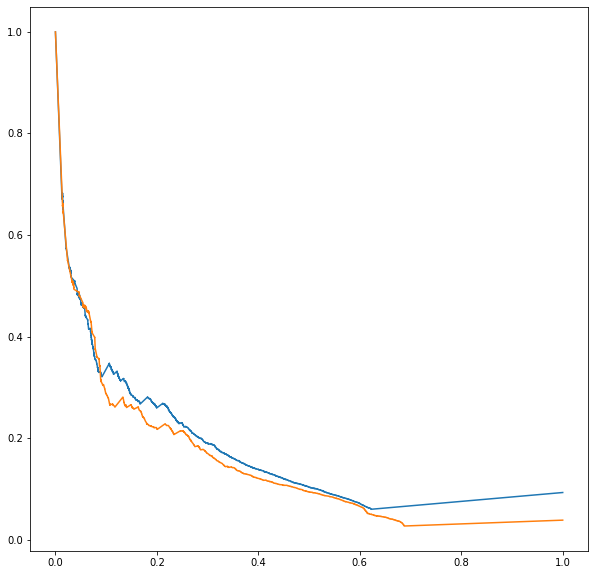

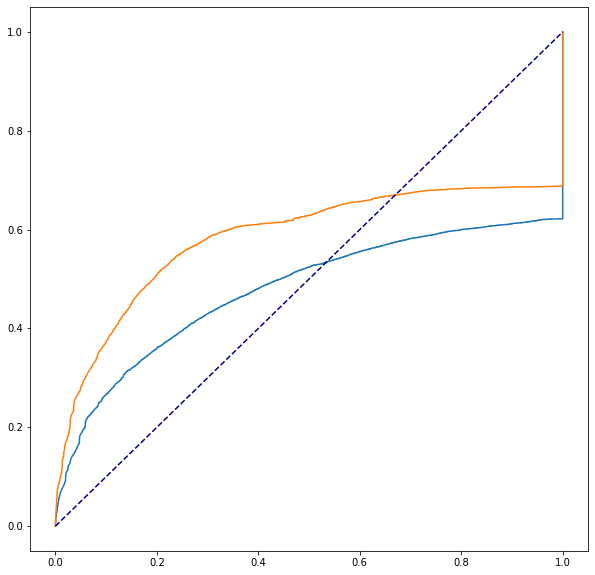

In [45]:
finaldf_naive.x2[finaldf_naive.score == 0 ] = 0

finaldf_embedder.x2[finaldf_embedder.score == 0 ] = 0


plt.figure( figsize = (10,10))
precision, recall, thresholds = precision_recall_curve(finaldf_naive.ytrue, finaldf_naive.proba_posi)
plt.plot(   recall , precision )

precision, recall, thresholds = precision_recall_curve(finaldf_embedder.ytrue, finaldf_embedder.x2)
plt.plot(   recall , precision )
plt.show()


plt.figure( figsize = (10,10))
fpr, tpr, thresholds = roc_curve( finaldf_naive.ytrue, finaldf_naive.proba_posi )
plt.plot(fpr ,tpr)
fpr, tpr, thresholds = roc_curve( finaldf_embedder.ytrue, finaldf_embedder.x2 )
plt.plot(fpr ,tpr)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.show()



In [42]:
print(len(targets.fam.unique()) )

27235


In [128]:
print(targets)
import math
import logging
logging.basicConfig(filename='chunklog.log',level=logging.DEBUG)

header1 = 
"""
AUTHOR David Moi
MODEL 1 
KEYWORDS Coevolution , IC

"""


header2 = 
"""
AUTHOR David Moi
MODEL 2 
KEYWORDS Coevolution, IC , GO embedding

"""
chunksize = 1000
chunks = math.ceiling ( len(targets.fam.unique())/1000 ) 
hogs = list(targets.fam.unique())


stamp = datetime.datetime.now().strftime('%m_%d_%Y_%H_%M_%S_%f')


with open( stamp + 'model1.txt' , 'w')as pred1 :
    with open(stamp + 'model2.txt'  , 'w') pred2:
        for i in range(chunks):
            if i == 0 :
                pred1.write(header1)
                pred2.write(header2)
            print(i / chunks)
            
            #predict for chunk of hogs
            chunk =  hogs[i*chunksize: i*chunksize + chunksize]
            for qhog in chunk:
                predchunk_naive = profiler_naive( qhog , p , gaf , c , nannot , hogs,  k = 10 , verbose = True , ignoreqhog = False )
                predchunk_embed =  embedding_kd_ap(qhog,  p, kdtree, embedmat , index , reverse_index , nannot, c , k  , nsuggestions , hogs , ignoreqhog = True)
            
            logging.info('chunk:' + str(i))

            #grab all targets for each hog

            for h in hogs:
                subtarget = targets[targets.fam == h ]

            #output csv for all targets in chunk


#chunk target rows and save outputs

#create csv 

              cafa_id      oma_id     fam species  taxcode
57070    T37020001074  ARATH00006  472976   ARATH     3702
69814    T37020003425  ARATH00010  483443   ARATH     3702
70000    T37020007063  ARATH00011  483592   ARATH     3702
3798     T37020007582  ARATH00013  182502   ARATH     3702
3236     T37020015139  ARATH00015  177269   ARATH     3702
82542    T37020009232  ARATH00020  684175   ARATH     3702
57872    T37020012135  ARATH00021  473862   ARATH     3702
67542    T37020007239  ARATH00025  481745   ARATH     3702
61295    T37020002614  ARATH00029  476412   ARATH     3702
4952     T37020005999  ARATH00033  187249   ARATH     3702
54778    T37020011574  ARATH00039  470677   ARATH     3702
56816    T37020005453  ARATH00043  472532   ARATH     3702
2966     T37020004465  ARATH00048  175633   ARATH     3702
5250     T37020001625  ARATH00049  188152   ARATH     3702
67246    T37020001981  ARATH00050  481665   ARATH     3702
83281    T37020002865  ARATH00051  685410   ARATH     37

In [40]:
#chunk predicition and save as you go along


for 


83525
11603854834
query:472976
           distance  cluster   jaccard   nterms         IC  score  \
41        28.460133       19  0.523438    500.0        NaN    NaN   
149        9.326344       28  1.000000    413.0        NaN    NaN   
226       10.925283       16  0.539062   1922.0        NaN    NaN   
1653      19.840259        9  0.515625    419.0        NaN    NaN   
1778      31.944899       22  0.527344     27.0        NaN    NaN   
1818      10.103156       26  1.000000    537.0        NaN    NaN   
1958      99.445250        6  0.539062    120.0        NaN    NaN   
2253       2.906660       23  1.000000   2081.0        NaN    NaN   
2262      52.794251       17  0.523438    129.0        NaN    NaN   
2440      35.341349       22  0.527344     27.0        NaN    NaN   
3407      16.332218       22  0.527344     27.0        NaN    NaN   
3674     178.610037        8  0.531250    316.0   3.700490    0.0   
3724      59.983533       17  0.523438    129.0        NaN    NaN   
377

E0117 11:43:35.760529 139650216625536 ultratb.py:155] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-48a401521f46>", line 13, in <module>
    print(embedding_kd_ap( h ,  p, tree, embedmat , index , reverse_index , nannot, c,  10   , 10  , hogs))
  File "<ipython-input-39-358d61903e8e>", line 45, in embedding_kd_ap
    godf = pd.DataFrame.from_dict( godict , orient = 'index')
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/pandas/core/frame.py", line 1138, in from_dict
    return cls(data, index=index, columns=columns, dtype=dtype)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/pandas/core/frame.py", line 392, in __init__
    mgr = init_dict(data, index, columns, dtype=dtype)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/pandas/core

KeyboardInterrupt: 

In [165]:
###### start machine learning profiler based function prediction here #####
#fit distribution params to jaccards and annot vecs?
#pull in terms in the embedding and use them as suggestions

def train_gengovec( qseqdfs , p ,  gaf , c , taxembed , embedmat , index  , taxindex , specdict , hogs, visdist  , k , obo,  batchsize ):
    #this is to generate the training data... some info on each go term relative to the profiles pulled in 
    #classifier decides y or n
    nannot = sum(c.values())
    #prob a good idea to generate a bunch of these and fit a normalizer on the data.
    #qseqdata is a generator of dataframes with columns = [ qseq , qhog ]
    #sequences are ordered by Hog number to avoid splitting them up
    govecs =[]
    ys=[]
    for qseqdata in qseqdfs:
        for hog in qseqdata.hog.unique():
            #proceed by hog
            #use the profiler to get all coev HOGs
            res = p.hog_query(hog_id = hog , k = k )
            res+= [str(hog)]
            hashes =  p.pull_hashes(res)
            #get all hog members and annotations
            members =  { r : [ m for m in hogs[int(r)] if m in gaf ] for r in res  }
            globalgodict = {  m + '_' + str(go) :{ 'fam':r , 'omaid':m ,  'GO':go , 'Tax':taxindex[specdict[m[0:5]]] , 'omaid':m } for r in res for m in members[r] for go in get_ancestors( gaf[m] , obo )  }
            if len(globalgodict)>0:
                #embed go and tax
                ggodf = pd.DataFrame.from_dict( globalgodict , orient = 'index')
                ggodf['name'] = ggodf.GO.map(lambda go : obo[ id2GO(go)].name )
                GO_embedding = { go:embedmat[ index[go], : ] for go in ggodf.GO.unique()  if go in index }
                Tax_embedding = { genome:taxembed[genome,:] for genome in ggodf.Tax.unique() }
                ICs = { go:np.log( nannot/c[go]) for go in ggodf.GO.unique()  if go in c }
                ICs.update( { go:max(ICs.values()) for go in ggodf.GO.unique() if go not in ICs }  )

                ggodf['GOembed'] = ggodf.GO.map(GO_embedding)
                ggodf['TaxEmbed'] = ggodf.Tax.map( Tax_embedding )
                ggodf['IC'] = ggodf.GO.map(ICs)
                
                for qhog in ggodf.fam.unique():
                    t0 = time.time()
                    godf = ggodf[ggodf.fam != qhog].copy()
                    godf = godf[ godf.fam != str(qhog) ]
                    
                    
                    if len(godf)>0:
                        #jaccard relative to qhog
                        qHOGgo =  [ embedmat[ index[go] ,:]  for m in ggodf[ggodf.fam == qhog].omaid for go in gaf[m] if go in index]
                        
                        if len(qHOGgo) == 0 :
                            #if no annotations then just use 'biological process' as annotation
                            qHOGavg = embedmat[ index[8150] ,: ]
                            qHOGstdv = [0,0,0]
                        else:
                            qHOGavg = np.mean( np.vstack(qHOGgo))
                            qHOGstdv = np.std( np.vstack(qHOGgo))
                        
                        counts = { go:len(godf[godf.GO==go]) for go in godf.GO.unique() }
                        Freqs = { go:counts[go]/len(godf) for go in godf.GO.unique() }
                        jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in godf.fam.unique() }
                        godf['jaccard'] = godf.fam.map(jaccards)
                        embedmat_matches = np.vstack(godf.GOembed[ ~godf.GOembed.isna() ])                        
                        GOembedavg = np.mean( embedmat_matches )
                        GOembedstd = np.std( embedmat_matches )
                        ICavg = np.mean( godf.IC )
                        ICstdv = np.std( godf.IC )
                        
                        if visdist:
                            plt.title('Jaccard')
                            plt.hist(godf.jaccard)
                            plt.show()
                            plt.title('IC')
                            plt.hist(list(ICs.values()))
                            plt.show()
                        
                        for go in godf.GO.unique():
                            sub = godf[ godf.GO == go ]
                            taxspread = np.std(np.vstack(sub.Tax))
                            taxcentroid = np.mean(np.vstack(sub.Tax))
                            if visdist:
                                plt.title( 'taxspread:'+  id2GO(go))
                                plt.scatter( taxembed[:,0], taxembed[:,1]  , alpha = .25 )
                                taxa = np.vstack(sub.TaxEmbed)
                                plt.scatter( taxa[:,0], taxa[:,1]  , alpha = 0.25)
                                plt.show()
                            
                            for seq in list(ggodf[ggodf.fam == qhog ].omaid.unique())[0:1000]:
                                #for each go for each qseq in qhog
                                seqTaxEmbed = taxembed[ taxindex[specdict[seq[0:5]]] , :  ]
                                #min taxonomic distance at which the annotation being tested is found
                                taxdists = np.vstack(sub.TaxEmbed.map( lambda x: np.linalg.norm(x-seqTaxEmbed)))
                                if visdist:
                                    plt.title('taxdist')
                                    plt.hist(taxdists)
                                    plt.show()
                                
                                taxdifference = np.vstack(sub.TaxEmbed.map( lambda x: x-seqTaxEmbed) )
                                taxdifferencespread = np.std(np.vstack(taxdifference))
                                taxdifferencecentroid = np.mean(np.vstack(taxdifference))
                                
                                if go in GO_embedding:
                                    govec = np.array( [ sub.IC.max() ,  ICavg , ICstdv , len(godf) , len(sub) ,  
                                                       sub.jaccard.max(),  sub.jaccard.mean() , 
                                                       sub.jaccard.std(), sub.jaccard.max(), sub.jaccard.min() , 
                                                       godf.jaccard.mean() , godf.jaccard.std(), godf.jaccard.max(), 
                                                       godf.jaccard.min(), np.amin(taxdists)  
                                                       ])

                                    govec = np.hstack([govec, seqTaxEmbed , GOembedavg , GOembedstd , GO_embedding[go] , qHOGavg, qHOGstdv , taxspread, taxcentroid , taxdifferencespread , taxdifferencecentroid])

                                    #does the prot have this annotation?
                                    
                                    if go in list(ggodf.GO[ ggodf.fam == str(qhog) ] ):

                                        y = [1]
                                    else:
                                        y =[0]
                                    govecs.append(govec)
                                    ys.append(y)

                                    if len(govecs)>batchsize:
                                        yield ( {'govec':np.vstack(govecs)} , {'y':np.vstack(ys)} )
                                        govecs = []
                                        ys=[]

                                    
#todo write a vec generator for targets and testing
def predict_targets( qhogs , p ,  gaf , c , taxembed , embedmat , index  , taxindex , specdict , hogs, k = 10 ,   visdist = False , obo = obo, batchsize = 100 ):
    nannot = sum(c.values())
    #prob a good idea to generate a bunch of these and fit a normalizer on the data.
    #qseqdata is a generator of dataframes with columns = [ qseq , qhog ]
    #sequences are ordered by Hog number to avoid splitting them up
    govecs =[]
    
    
    for qseqdata in qseqdfs:
        for hog in qseqdata.hog.unique():
            #proceed by hog
            #use the profiler to get all coev HOGs
            res = p.hog_query(hog_id = hog , k = k )
            res+= [str(hog)]
            hashes =  p.pull_hashes(res)
            #get all hog members and annotations
            members =  { r : [ m for m in hogs[int(r)] if m in gaf ] for r in res  }
            globalgodict = {  m + '_' + str(go) :{ 'fam':r , 'omaid':m ,  'GO':go , 'Tax':taxindex[specdict[m[0:5]]] , 'omaid':m } for r in res for m in members[r] for go in get_ancestors( gaf[m] , obo )  }
            if len(globalgodict)>0:
                #embed go and tax
                ggodf = pd.DataFrame.from_dict( globalgodict , orient = 'index')
                ggodf['name'] = ggodf.GO.map(lambda go : obo[ id2GO(go)].name )
                GO_embedding = { go:embedmat[ index[go], : ] for go in ggodf.GO.unique()  if go in index }
                Tax_embedding = { genome:taxembed[genome,:] for genome in ggodf.Tax.unique() }
                ICs = { go:np.log(c[go]/nannot) for go in ggodf.GO.unique()  if go in c }
                
                ggodf['GOembed'] = ggodf.GO.map(GO_embedding)
                ggodf['TaxEmbed'] = ggodf.Tax.map( Tax_embedding )
                ggodf['IC'] = ggodf.GO.map(ICs)
                if len(godf)>0:
                    #jaccard relative to qhog
                    qHOGgo =  [ embedmat[ index[go] ,:]  for m in ggodf[ggodf.fam == qhog].omaid for go in gaf[m] if go in index]

                    if len(qHOGgo) == 0 :
                        #if no annotations then just use 'biological process' as annotation
                        qHOGavg = embedmat[ index[8150] ,: ]
                        qHOGstdv = [0,0,0]
                    else:
                        qHOGavg = np.mean( np.vstack(qHOGgo))
                        qHOGstdv = np.std( np.vstack(qHOGgo))

                    counts = { go:len(godf[godf.GO==go]) for go in godf.GO.unique() }
                    Freqs = { go:counts[go]/len(godf) for go in godf.GO.unique() }
                    jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in godf.fam.unique() }
                    godf['jaccard'] = godf.fam.map(jaccards)
                    embedmat_matches = np.vstack(godf.GOembed[ ~godf.GOembed.isna() ])                        
                    GOembedavg = np.mean( embedmat_matches )
                    GOembedstd = np.std( embedmat_matches )
                    ICavg = np.mean( godf.IC )
                    ICstdv = np.std( godf.IC )

                    if visdist:
                        plt.title('Jaccard')
                        plt.hist(godf.jaccard)
                        plt.show()
                        plt.title('IC')
                        plt.hist(list(ICs.values()))
                        plt.show()

                    for go in godf.GO.unique():
                        sub = godf[ godf.GO == go ]
                        taxspread = np.std(np.vstack(sub.Tax))
                        taxcentroid = np.mean(np.vstack(sub.Tax))
                        if visdist:
                            plt.title( 'taxspread:'+  id2GO(go))
                            plt.scatter( taxembed[:,0], taxembed[:,1]  , alpha = .25 )
                            taxa = np.vstack(sub.TaxEmbed)
                            plt.scatter( taxa[:,0], taxa[:,1]  , alpha = 0.25)
                            plt.show()
                        for seq in godf[godf.fam == str(qhog) ].omaid.unique():
                            #for each go for each qseq in qhog
                            seqTaxEmbed = taxembed[ taxindex[specdict[seq[0:5]]] , :  ]
                            #min taxonomic distance at which the annotation being tested is found
                            taxdists = np.vstack(sub.TaxEmbed.map( lambda x: np.linalg.norm(x-seqTaxEmbed)))
                            if visdist:
                                plt.title('taxdist')
                                plt.hist(taxdists)
                                plt.show()
                            taxdifference = np.vstack(sub.TaxEmbed.map( lambda x: x-seqTaxEmbed) )
                            taxdifferencespread = np.std(np.vstack(taxdifference))
                            taxdifferencecentroid = np.mean(np.vstack(taxdifference))
                            if go in GO_embedding:
                                govec = np.array( [ sub.IC.max() ,  ICavg , ICstdv , len(godf) , len(sub) ,  
                                                   sub.jaccard.max(),  sub.jaccard.mean() , 
                                                   sub.jaccard.std(), sub.jaccard.max(), sub.jaccard.min() , 
                                                   godf.jaccard.mean() , godf.jaccard.std(), godf.jaccard.max(), 
                                                   godf.jaccard.min(), np.amin(taxdists)  
                                                   ])

                                govec = np.hstack([govec, seqTaxEmbed , GOembedavg , GOembedstd , GO_embedding[go] , qHOGavg, qHOGstdv , taxspread, taxcentroid , taxdifferencespread , taxdifferencecentroid])
                                govecs.append(govec)

                                if len(govecs)>batchsize:
                                    #return vec of GO term
                                    yield ( {'govec':np.vstack(govecs)}  )
                                    

                    

In [166]:

train_govecs = train_gengovec( hogiterator,  p ,  gaf , c , taxembedscaled , embedmat_scaled , index  , taxindex , specdict , hogs, k = 20 ,   visdist = False , obo = obo, batchsize = 100  )

In [183]:
#use this net for predicting binary yes or no for each go term in a set given a set of inputs
import numpy as np
from keras.optimizers import *
from keras.layers import *
from keras.callbacks import *
from keras.models import load_model
import datetime
import keras
global max_epochs
from keras.models import Model
from keras.layers import Flatten, Input, Dense

from keras.backend import tensorflow_backend as K
epsilon = K.epsilon()
stamp = datetime.datetime.now().strftime('%m_%d_%Y_%H_%M_%S_%f')

import tensorflow as tf

################################################################################
dirlocal = './'
dataset = 'full' # 'sample' or 'full'

modelfile = 'model-' + str(stamp) + '.h5'

densedim = 10
layers = 2

govec_test = next( train_govecs )
print( govec_test)

({'govec': array([[ 8.56623560e+00,  6.69238542e+00,  2.82083895e+00, ...,
         2.17407143e+03,  5.28861847e-02, -5.94220393e-03],
       [ 7.40622614e+00,  6.69238542e+00,  2.82083895e+00, ...,
         2.17407143e+03,  5.28917166e-02, -5.92735091e-03],
       [ 7.40622614e+00,  6.69238542e+00,  2.82083895e+00, ...,
         2.17407143e+03,  2.73025128e-02, -3.64634723e-03],
       ...,
       [ 5.31832043e+00,  6.69238542e+00,  2.82083895e+00, ...,
         2.17443750e+03,  5.08229333e-02, -5.45536337e-03],
       [ 4.44678677e+00,  6.69238542e+00,  2.82083895e+00, ...,
         2.17346154e+03,  5.48618092e-02, -6.38330098e-03],
       [ 4.44678677e+00,  6.69238542e+00,  2.82083895e+00, ...,
         2.17346154e+03,  2.67460069e-02, -4.10229730e-03]])}, {'y': array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [

In [ ]:

a = Input(shape= ( govec_test[0]['govec'].shape[1] , )   , name='govec' ) 
#perceptron...
for i in range( layers):
    if i == 0:
        b = Dense(densedim  )(a)
        #layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones')
        #b = layer(b)
    else:
        
        b = Dense(densedim )(b)
        layer = BatchNormalization(axis=0, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones')
        #b = layer(b)

#layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones')
#final softmax
layer = Dense( 1, activation = 'sigmoid' , name = 'y')
final = layer(b)

#layer = Dense(1,activation = 'sigmoid' , name = 'y')
#final = layer(b)

model = Model(inputs=a, outputs=final)

o = keras.optimizers.RMSprop(lr=.0000001, rho=0.09)
#o = keras.optimizers.Adadelta(lr=.050, rho=0.95)
#o =  keras.optimizers.SGD(lr=0.1, momentum=0.001, nesterov=False)

model.compile( optimizer=o, loss= 'mean_squared_error' , metrics=['accuracy'])
max_len = 3000
mc = ModelCheckpoint(modelfile, monitor = 'loss', mode = 'auto', verbose = 1, save_best_only = False)
lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience= 10 , min_lr=0.00001)
es = EarlyStopping(monitor = 'loss', mode = 'min', verbose = 2, patience = 100)
####change this
history = model.fit_generator( train_govecs  ,verbose = 1 , steps_per_epoch= 1000 , epochs = 100000 , callbacks=[es, lr])